In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

df = pd.read_csv('loan_data_2007_2014.csv')

In [ ]:
df.head(2)

# Exploratory Data Analysis

In [ ]:
data = df.copy()
data.info()

**term** and **emp_length** should be in integer type.<br>
**earliest_cr_line, issue_d, last_pymnt_d, next_pymnt_d,** and **last_credit_pull_d** should be in date type

#### *cross table of home ownership, loan status, and average interest rate*

In [ ]:
pd.crosstab(data['home_ownership'], data['loan_status'], values=data['int_rate'], aggfunc='mean').round(2)

In [ ]:
plt.scatter(data['annual_inc'], data['int_rate'], c='blue', alpha=0.5)
plt.xlabel('Annual Income')
plt.ylabel('Interest Rate')

#### *cross table of purpose and loan status*

In [ ]:
pd.crosstab(data['purpose'], data['loan_status'], margins=True)

#### *cross table of home ownership, loan status, and grade*

In [ ]:
pd.crosstab(data['home_ownership'], 
            [data['loan_status'], data['grade']]
           )

#### *cross table of home ownership, loan status, and average percent income*

In [ ]:
pd.crosstab(data['home_ownership'], data['loan_status'], values=data['annual_inc'], aggfunc='mean').round(2)

#### *a box plot of percentage income by loan status* 

In [ ]:
data.boxplot(column=['annual_inc'], by='loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.xticks(rotation = 90)
plt.show()

#### *cross table for loan status, home ownership, and the max employment length* 

In [ ]:
pd.crosstab(data['loan_status'], data['home_ownership'], values=data['emp_length_int'], aggfunc='max')

# General Preprocessing

## Correcting Data Types

In [ ]:
data['emp_length'].unique()

In [ ]:
data['emp_length_int'] = data['emp_length'].str.replace('\+ years','')
data['emp_length_int'] = data['emp_length_int'].str.replace('< 1 year',str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace('n/a',str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace(' years','')
data['emp_length_int'] = data['emp_length_int'].str.replace(' year','')

data['emp_length_int'] = pd.to_numeric(data['emp_length_int'])
data.drop(columns=['emp_length'], inplace=True)

For most credit risk models, especially for **probability of default**, columns like **person_emp_length** and **person_home_ownership** are common to begin investigating.

In [ ]:
pd.crosstab(data['emp_length_int'], data['home_ownership'], margins=True)

In [ ]:
data['term'].unique()

In [ ]:
data['term_int'] = data['term'].str.replace(' months', '')
data['term_int'] = pd.to_numeric(data['term_int'])
data.drop(columns=['term'], inplace=True)

In [ ]:
d_str = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

data['earliest_cr_line_date'] = pd.to_datetime(data[d_str[0]], format='%b-%y')
data['issue_d_date'] = pd.to_datetime(data[d_str[1]], format='%b-%y')
data['last_pymnt_d_date'] = pd.to_datetime(data[d_str[2]], format='%b-%y')
data['next_pymnt_d_date'] = pd.to_datetime(data[d_str[3]], format='%b-%y')
data['last_credit_pull_d_date'] = pd.to_datetime(data[d_str[4]], format='%b-%y')

## General Feature Extraction

In [ ]:
time_passed_days = pd.to_datetime('2023-06-01') - data['earliest_cr_line_date']
data['mths_since_earliest_cr_line'] = round(pd.to_numeric(time_passed_days/np.timedelta64(1,'M')))

In [ ]:
data['mths_since_earliest_cr_line'].describe()

There is a negative value in the min section, which is impossible to have a negative value for months differences

Since we have 466.285 and only 1169 records with negative values, we can impute the value with other since it won't affect much to our analysis

In [ ]:
data['mths_since_earliest_cr_line'][data.mths_since_earliest_cr_line < 0] = data['mths_since_earliest_cr_line'].max()

In [ ]:
issue_time_passed_days = pd.to_datetime('2023-06-01') - data['issue_d_date']
data['mths_since_issue_date'] = round(pd.to_numeric(time_passed_days/np.timedelta64(1,'M')))

data['mths_since_issue_date'][data.mths_since_issue_date < 0] = data['mths_since_issue_date'].max()
data['mths_since_issue_date'].describe()

## Deleting Unnecessary Feature (NaN Feature)

In [ ]:
empty_features = ['annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
                  'inq_fi','total_cu_tl','inq_last_12m']
data.drop(columns=empty_features, inplace=True)

## Handling Missing Value

In [ ]:
possible_knn_features = [
    'total_rev_hi_lim', 'annual_inc', 'revol_util','tot_cur_bal'
]

missing_nums_data = [
            'mths_since_earliest_cr_line','acc_now_delinq','total_acc', 
            'pub_rec', 'open_acc', 'inq_last_6mths', 'delinq_2yrs', 'emp_length_int', 
            'mths_since_last_delinq', 'collections_12_mths_ex_med', 'collections_12_mths_ex_med', 
            'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'mths_since_issue_date', 'mths_since_last_record'
            ]

In [ ]:
from sklearn.impute import KNNImputer

nums_data = data[possible_knn_features].copy()

KNNImputer = KNNImputer(n_neighbors=5)
impute_nums_data = pd.DataFrame(KNNImputer.fit_transform(nums_data), columns=nums_data.columns)

In [ ]:
for i in range(len(missing_nums_data)):
    data[missing_nums_data[i]].fillna(0, inplace=True)

In [ ]:
missing_cats_data = ['emp_title', 'desc', 'title']

In [ ]:
from sklearn.impute import SimpleImputer

cats_data = data[missing_cats_data].copy()

imputer = SimpleImputer(strategy='constant', fill_value='missing')
impute_cats_data = pd.DataFrame(imputer.fit_transform(cats_data), columns = cats_data.columns)

In [ ]:
imputed_data = impute_nums_data.join(impute_cats_data)

In [ ]:
data = data.join(imputed_data)

# Export Clean Dataset

In [2]:
data = pd.read_csv('cleaned_data.csv')

# Defining WoE and IV Calculation

In [3]:
def woe_discreat(X_train, discreat_var_name, y_train):
    df = pd.concat([X_train[discreat_var_name], y_train], axis=1)
    
    #Calculate the number of observations and the proportion of good values (which is 1)
    #Since the good_bad feature only range from 0-1, calculate the mean good_bad will gives us the same result of the proportion of the good values (1)
    n_obs = df.groupby(discreat_var_name, as_index = False).agg(n_obs = (discreat_var_name, 'count'))
    prop_good = df.groupby(discreat_var_name, as_index = False).agg(prop_good = (y_train.name,'mean'))
    
    df = pd.concat([n_obs, prop_good], axis=1)
    
    #Removing the duplicate feature (only return feature from index 0,1,and 3)
    df = df.iloc[:,[0,1,3]]
    
    #calculate the percentage of observations
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    
    #calculate the n_good and the n_bad using the following formula
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1-df['prop_good']) * df['n_obs']
    
    #calculate the percentage of the n_good and the n_bad
    df['prcnt_good'] = df['n_good']/df['n_good'].sum()
    df['prcnt_bad'] = df['n_bad']/df['n_bad'].sum()
    
    #calculate the WoE Score
    df['woe'] = np.log(df['prcnt_good'] / df['prcnt_bad'])
    
    #calculate Information Value (IV)
    df['IV'] = (df['prcnt_good'] - df['prcnt_bad'])*df['woe']
    df['IV'] = df['IV'].sum()
    
    #calculate the difference of good loan and the woe
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_woe'] = df['woe'].diff().abs()
    
    df = df.sort_values(by='woe')
    
    return df

In [4]:
def plot_woe(df_woe, rotation_of_axis_labels=0):
    x = np.array(df_woe.iloc[:, 0].apply(str)) #retrieve the grade feature
    y = df_woe['woe']
    
    plt.figure(figsize=(18,6))
    plt.plot(x,y, marker = 'o', linestyle='--', color='k')
    plt.xlabel(df_woe.columns[0])
    plt.ylabel('Weight of Evidence')
    
    plt.title(str('Weight of Evidence by' + df_woe.columns[0]))
    plt.xticks(rotation = rotation_of_axis_labels)
    plt.grid()

In [5]:
def woe_ordered_continuous(X_train, cont_var_name, y_train):
    df = pd.concat([X_train[cont_var_name], y_train], axis=1)
    
    #Calculate the number of observations and the proportion of good values (which is 1)
    #Since the good_bad feature only range from 0-1, calculate the mean good_bad will gives us the same result of the proportion of the good values (1)
    n_obs = df.groupby(cont_var_name, as_index = False).agg(n_obs = (cont_var_name, 'count'))
    prop_good = df.groupby(cont_var_name, as_index = False).agg(prop_good = (y_train.name,'mean'))
    
    df = pd.concat([n_obs, prop_good], axis=1)
    
    #Removing the duplicate feature (only return feature from index 0,1,and 3)
    df = df.iloc[:,[0,1,3]]
    
    #calculate the percentage of observations
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    
    #calculate the n_good and the n_bad using the following formula
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1-df['prop_good']) * df['n_obs']
    
    #calculate the percentage of the n_good and the n_bad
    df['prcnt_good'] = df['n_good']/df['n_good'].sum()
    df['prcnt_bad'] = df['n_bad']/df['n_bad'].sum()
    
    #calculate the WoE Score
    df['woe'] = np.log(df['prcnt_good'] / df['prcnt_bad'])
    
    #calculate Information Value (IV)
    df['IV'] = (df['prcnt_good'] - df['prcnt_bad'])*df['woe']
    df['IV'] = df['IV'].sum()
    
    #calculate the difference of good loan and the woe
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_woe'] = df['woe'].diff().abs()
    
    return df

# EL = PD x LGD x EAD

# Probability of Default (PD)

## Splitting Data (80/20)

In [6]:
# Determine which is the good and bad value from the loan_status
data['good_bad'] = np.where(data['loan_status'].isin(['Charged Off', 'Late (16-30 days)','Default',
                                                     'Does not meet the credit policy. Status:Charged Off']),0,1)

In [7]:
X = data.drop(columns=['good_bad'])
y = data['good_bad']

In [8]:
from sklearn.model_selection import train_test_split

X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X,y,test_size=0.2, random_state=42)

## Encoding Categorical Values

In [9]:
cat_discreat = ['grade', 'home_ownership','verification_status','purpose','addr_state', 'initial_list_status']

In [10]:
data_dummies_train = [pd.get_dummies(X_train_pd[cat_discreat[0]], prefix='grade', prefix_sep=':'),
                pd.get_dummies(X_train_pd[cat_discreat[1]], prefix='home_ownership', prefix_sep=':'),
                pd.get_dummies(X_train_pd[cat_discreat[2]], prefix='ver_status', prefix_sep=':'),
                pd.get_dummies(X_train_pd[cat_discreat[3]], prefix='purpose', prefix_sep=':'),
                pd.get_dummies(X_train_pd[cat_discreat[4]], prefix='addr', prefix_sep=':'),
                pd.get_dummies(X_train_pd[cat_discreat[5]], prefix='list_status', prefix_sep=':')
               ]

data_dummies_test = [pd.get_dummies(X_test_pd[cat_discreat[0]], prefix='grade', prefix_sep=':'),
                pd.get_dummies(X_test_pd[cat_discreat[1]], prefix='home_ownership', prefix_sep=':'),
                pd.get_dummies(X_test_pd[cat_discreat[2]], prefix='ver_status', prefix_sep=':'),
                pd.get_dummies(X_test_pd[cat_discreat[3]], prefix='purpose', prefix_sep=':'),
                pd.get_dummies(X_test_pd[cat_discreat[4]], prefix='addr', prefix_sep=':'),
                pd.get_dummies(X_test_pd[cat_discreat[5]], prefix='list_status', prefix_sep=':')
               ]

In [11]:
#Convert into dataframe
data_dummies_train = pd.concat(data_dummies_train, axis=1)

data_dummies_test = pd.concat(data_dummies_test, axis=1)

In [12]:
X_train_pd = pd.concat([X_train_pd, data_dummies_train], axis=1)
X_test_pd = pd.concat([X_test_pd, data_dummies_test], axis=1)

In [13]:
X_train_pd.head(2)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,home_ownership,verification_status,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,emp_length_int,term_int,earliest_cr_line_date,issue_d_date,last_pymnt_d_date,next_pymnt_d_date,last_credit_pull_d_date,mths_since_earliest_cr_line,mths_since_issue_date,annual_inc,revol_util,tot_cur_bal,total_rev_hi_lim,emp_title,desc,title,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,ver_status:Not Verified,ver_status:Source Verified,ver_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr:AK,addr:AL,addr:AR,addr:AZ,addr:CA,addr:CO,addr:CT,addr:DC,addr:DE,addr:FL,addr:GA,addr:HI,addr:IA,addr:ID,addr:IL,addr:IN,addr:KS,addr:KY,addr:LA,addr:MA,addr:MD,addr:ME,addr:MI,addr:MN,addr:MO,addr:MS,addr:MT,addr:NC,addr:NE,addr:NH,addr:NJ,addr:NM,addr:NV,addr:NY,addr:OH,addr:OK,addr:OR,addr:PA,addr:RI,addr:SC,addr:SD,addr:TN,addr:TX,addr:UT,addr:VA,addr:VT,addr:WA,addr:WI,addr:WV,addr:WY,list_status:f,list_status:w
427211,427211,12796369,14818505,24000,24000,24000.0,8.90,762.08,A,A5,MORTGAGE,Source Verified,Current,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,295xx,SC,21.91,0.0,1.0,0.0,0.0,20.0,0.0,30489,32.0,f,10098.3,10098.3,16765.76000,16765.76,13901.7,2864.06,0.0,0.0,0.0,762.08,0.0,0.0,1,INDIVIDUAL,0.0,0.0,3.0,36,1986-12-01,2014-03-01,2016-01-01,2016-02-01,2016-01-01,438.0,438.0,77000.0,53.5,348253.0,57000.0,Supervisor inventory management,Borrower added on 03/12/14 > I have 5 credit...,Debt consolidation,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
206088,206088,1439740,1691948,10000,10000,10000.0,14.33,343.39,C,C1,MORTGAGE,Not Verified,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,070xx,NJ,7.49,1.0,2.0,18.0,0.0,15.0,0.0,15836,38.0,f,0.0,0.0,12357.02066,12357.02,10000.0,2357.02,0.0,0.0,0.0,355.11,0.0,0.0,1,INDIVIDUAL,0.0,0.0,6.0,36,1997-12-01,2012-08-01,2015-08-01,NaN,2015-07-01,306.0,306.0,112000.0,53.1,233553.2,66660.0,mizuho corporate bank,Borrower added on 07/23/12 > I was looking f...,Credit card consolidation,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Feature Selection using WoE and IV - Categorical Features

In [14]:
cat_discreat

['grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status']

In [15]:
woe_discreat(X_train_pd, 'grade', y_train_pd)

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
6,G,2654,0.754333,0.007115,2002.0,652.0,0.005945,0.017982,-1.106852,0.277898,0.022590,0.125967
5,F,10530,0.776923,0.028228,8181.0,2349.0,0.024293,0.064784,-0.980885,0.277898,0.049898,0.315437
4,E,28612,0.826821,0.076702,23657.0,4955.0,0.070247,0.136656,-0.665448,0.277898,0.037451,0.287973
3,D,61498,0.864272,0.164862,53151.0,8347.0,0.157826,0.230205,-0.377475,0.277898,0.035154,0.339633
2,C,100245,0.899426,0.268733,90163.0,10082.0,0.267730,0.278055,-0.037842,0.277898,0.029773,0.383581
1,B,109730,0.929199,0.294160,101961.0,7769.0,0.302762,0.214264,0.345739,0.277898,0.035576,0.735695
0,A,59759,0.964775,0.160200,57654.0,2105.0,0.171197,0.058055,1.081435,0.277898,NaN,NaN


In [16]:
woe_discreat(X_train_pd, 'home_ownership', y_train_pd)

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
3,OTHER,137,0.795620,0.000367,109.0,28.0,0.000324,0.000772,-0.869566,inf,0.054380,0.375458
2,NONE,40,0.850000,0.000107,34.0,6.0,0.000101,0.000165,-0.494109,inf,0.064483,0.635039
5,RENT,150599,0.887722,0.403720,133690.0,16909.0,0.396978,0.466339,-0.161032,inf,0.017459,0.188487
4,OWN,33295,0.905181,0.089256,30138.0,3157.0,0.089492,0.087068,0.027455,inf,0.109561,0.897021
1,MORTGAGE,188956,0.914483,0.506546,172797.0,16159.0,0.513102,0.445655,0.140931,inf,0.085517,inf
0,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf,NaN,NaN


In [17]:
woe_discreat(X_train_pd, 'verification_status', y_train_pd)

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
2,Verified,134414,0.885086,0.360332,118968.0,15446.0,0.353263,0.425991,-0.187205,0.02279,0.025428,0.278423
1,Source Verified,120030,0.910514,0.321772,109289.0,10741.0,0.324522,0.296230,0.091218,0.02279,0.004550,0.057174
0,Not Verified,118584,0.915064,0.317896,108512.0,10072.0,0.322215,0.277779,0.148392,0.02279,NaN,NaN


In [18]:
woe_discreat(X_train_pd, 'purpose', y_train_pd)

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
11,small_business,5582,0.795951,0.014964,4443.0,1139.0,0.013193,0.031413,-0.867530,0.041638,0.075935,0.556560
3,educational,333,0.801802,0.000893,267.0,66.0,0.000793,0.001820,-0.831116,0.041638,0.098195,0.799595
8,moving,2392,0.852425,0.006412,2039.0,353.0,0.006055,0.009736,-0.474963,0.041638,0.029226,0.254406
10,renewable_energy,281,0.871886,0.000753,245.0,36.0,0.000728,0.000993,-0.310970,0.041638,0.001393,0.012528
9,other,18884,0.873279,0.050624,16491.0,2393.0,0.048968,0.065997,-0.298443,0.041638,0.020854,0.176520
5,house,1830,0.873770,0.004906,1599.0,231.0,0.004748,0.006371,-0.293994,0.041638,0.038792,0.410615
7,medical,3684,0.881650,0.009876,3248.0,436.0,0.009645,0.012025,-0.220557,0.041638,0.030944,0.337576
13,wedding,1887,0.882883,0.005059,1666.0,221.0,0.004947,0.006095,-0.208691,0.041638,0.007122,0.070774
12,vacation,1991,0.890005,0.005337,1772.0,219.0,0.005262,0.006040,-0.137917,0.041638,0.094054,0.729613
2,debt_consolidation,219183,0.899997,0.587578,197264.0,21919.0,0.585755,0.604512,-0.031521,0.041638,0.024220,0.303887


In [19]:
woe_discreat(X_train_pd, 'addr_state', y_train_pd)

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
28,NE,13,0.461538,0.000035,6.0,7.0,0.000018,0.000193,-2.382860,inf,0.436443,2.329143
12,IA,13,0.769231,0.000035,10.0,3.0,0.000030,0.000083,-1.024737,inf,0.125322,0.934140
32,NV,5221,0.880483,0.013996,4597.0,624.0,0.013650,0.017210,-0.231701,inf,0.012047,0.119841
9,FL,25211,0.889215,0.067585,22418.0,2793.0,0.066568,0.077029,-0.145962,inf,0.013980,0.150498
1,AL,4671,0.890387,0.012522,4159.0,512.0,0.012350,0.014121,-0.134004,inf,0.032843,0.392363
31,NM,2075,0.892530,0.005563,1852.0,223.0,0.005499,0.006150,-0.111860,inf,0.007296,0.078445
11,HI,2001,0.894553,0.005364,1790.0,211.0,0.005315,0.005819,-0.090597,inf,0.013140,0.147665
24,MO,6017,0.894632,0.016130,5383.0,634.0,0.015984,0.017485,-0.089757,inf,0.008065,0.088604
4,CA,57199,0.896432,0.153337,51275.0,5924.0,0.152256,0.163380,-0.070518,inf,0.006287,0.069609
17,KY,3587,0.896850,0.009616,3217.0,370.0,0.009553,0.010204,-0.066008,inf,0.018924,0.223562


In [20]:
woe_discreat(X_train_pd, 'initial_list_status', y_train_pd)

,initial_list_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,f,242514,0.890213,0.650123,215889.0,26625.0,0.64106,0.7343,-0.135796,0.040708,NaN,NaN
1,w,130514,0.926184,0.349877,120880.0,9634.0,0.35894,0.2657,0.300790,0.040708,0.035972,0.436586


The following are the selected feature with the **IV** score **> 0.02**:
1. grade
2. home_ownership
3. verification_status
4. purpose
5. addr_state
6. initial_list_status

## Feature Extraction - Categorical Features

In [21]:
#Create a dummy variable to grouped the home_ownership values

X_train_pd['home_ownership:RENT_OTHER_NONE_ANY'] = sum([
    X_train_pd['home_ownership:RENT'], X_train_pd['home_ownership:OTHER'],
    X_train_pd['home_ownership:NONE'], X_train_pd['home_ownership:ANY']
])

X_test_pd['home_ownership:RENT_OTHER_NONE_ANY'] = sum([
    X_test_pd['home_ownership:RENT'], X_test_pd['home_ownership:OTHER'],
    X_test_pd['home_ownership:NONE']
])

In [22]:
#Create a dummy variable to grouped the addr_state values
X_train_pd['adrr_state:NE_IA_NV_FL_AL_NM_HI_MO'] = sum([
    X_train_pd['addr:NE'], X_train_pd['addr:IA'], X_train_pd['addr:NV'], X_train_pd['addr:FL'], X_train_pd['addr:AL'],
    X_train_pd['addr:NM'], X_train_pd['addr:HI'], X_train_pd['addr:MO']
])

X_train_pd['adrr_state:CA'] = X_train_pd['addr:CA']

X_train_pd['adrr_state:KY_VA'] = sum([
    X_train_pd['addr:KY'], X_train_pd['addr:VA']
])

X_train_pd['adrr_state:NY'] = X_train_pd['addr:NY']

X_train_pd['adrr_state:NC_UT'] = sum([
    X_train_pd['addr:NC'], X_train_pd['addr:UT']
])

X_train_pd['adrr_state:MD_NJ_LA_OK_MI_TN'] = sum([
    X_train_pd['addr:MD'], X_train_pd['addr:NJ'], X_train_pd['addr:LA'], X_train_pd['addr:OK'], X_train_pd['addr:MI'],
    X_train_pd['addr:TN']
])

X_train_pd['adrr_state:MN_AZ_DE_PA_AR_OH'] = sum([
    X_train_pd['addr:MN'], X_train_pd['addr:AZ'], X_train_pd['addr:DE'], X_train_pd['addr:PA'], X_train_pd['addr:AR'],
    X_train_pd['addr:OH']
])

X_train_pd['adrr_state:WA_MA_IN_GA_RI_OR'] = sum([
    X_train_pd['addr:WA'], X_train_pd['addr:MA'], X_train_pd['addr:IN'], X_train_pd['addr:GA'], X_train_pd['addr:RI'],
    X_train_pd['addr:OR']
])

X_train_pd['adrr_state:WI_SD_CT'] = sum([
    X_train_pd['addr:WI'], X_train_pd['addr:SD'], X_train_pd['addr:CT']
])

X_train_pd['adrr_state:TX'] = X_train_pd['addr:TX']

X_train_pd['adrr_state:KS_IL_MT'] = sum([
    X_train_pd['addr:KS'], X_train_pd['addr:IL'], X_train_pd['addr:MT']
])

X_train_pd['adrr_state:CO_SC_VT_AK'] = sum([
    X_train_pd['addr:CO'], X_train_pd['addr:SC'], X_train_pd['addr:VT'], X_train_pd['addr:AK']
])

X_train_pd['adrr_state:MS_NH_WY_WV_DC_ME_ID'] = sum([
    X_train_pd['addr:MS'], X_train_pd['addr:NH'], X_train_pd['addr:WY'], X_train_pd['addr:WV'], X_train_pd['addr:DC'],
    X_train_pd['addr:ME'], X_train_pd['addr:ID']
])

In [23]:
#Create a dummy variable to grouped the addr_state values
X_test_pd['adrr_state:NE_IA_NV_FL_AL_NM_HI_MO'] = sum([
    X_test_pd['addr:NE'], X_test_pd['addr:IA'], X_test_pd['addr:NV'], X_test_pd['addr:FL'], X_test_pd['addr:AL'],
    X_test_pd['addr:NM'], X_test_pd['addr:HI'], X_test_pd['addr:MO']
])

X_test_pd['adrr_state:CA'] = X_test_pd['addr:CA']

X_test_pd['adrr_state:KY_VA'] = sum([
    X_test_pd['addr:KY'], X_test_pd['addr:VA']
])

X_test_pd['adrr_state:NY'] = X_test_pd['addr:NY']

X_test_pd['adrr_state:NC_UT'] = sum([
    X_test_pd['addr:NC'], X_test_pd['addr:UT']
])

X_test_pd['adrr_state:MD_NJ_LA_OK_MI_TN'] = sum([
    X_test_pd['addr:MD'], X_test_pd['addr:NJ'], X_test_pd['addr:LA'], X_test_pd['addr:OK'], X_test_pd['addr:MI'],
    X_test_pd['addr:TN']
])

X_test_pd['adrr_state:MN_AZ_DE_PA_AR_OH'] = sum([
    X_test_pd['addr:MN'], X_test_pd['addr:AZ'], X_test_pd['addr:DE'], X_test_pd['addr:PA'], X_test_pd['addr:AR'],
    X_test_pd['addr:OH']
])

X_test_pd['adrr_state:WA_MA_IN_GA_RI_OR'] = sum([
    X_test_pd['addr:WA'], X_test_pd['addr:MA'], X_test_pd['addr:IN'], X_test_pd['addr:GA'], X_test_pd['addr:RI'],
    X_test_pd['addr:OR']
])

X_test_pd['adrr_state:WI_SD_CT'] = sum([
    X_test_pd['addr:WI'], X_test_pd['addr:SD'], X_test_pd['addr:CT']
])

X_test_pd['adrr_state:TX'] = X_test_pd['addr:TX']

X_test_pd['adrr_state:KS_IL_MT'] = sum([
    X_test_pd['addr:KS'], X_test_pd['addr:IL'], X_test_pd['addr:MT']
])

X_test_pd['adrr_state:CO_SC_VT_AK'] = sum([
    X_test_pd['addr:CO'], X_test_pd['addr:SC'], X_test_pd['addr:VT'], X_test_pd['addr:AK']
])

X_test_pd['adrr_state:MS_NH_WY_WV_DC_ME_ID'] = sum([
    X_test_pd['addr:MS'], X_test_pd['addr:NH'], X_test_pd['addr:WY'], X_test_pd['addr:WV'], X_test_pd['addr:DC'],
    X_test_pd['addr:ME'], X_test_pd['addr:ID']
])

In [24]:
X_train_pd['purpose:small_business_educational_moving'] = sum([
    X_train_pd['purpose:small_business'], X_train_pd['purpose:educational'], X_train_pd['purpose:moving']
])

X_train_pd['purpose:renewable_energy_other_house'] = sum([
    X_train_pd['purpose:renewable_energy'], X_train_pd['purpose:other'], X_train_pd['purpose:house']
])

X_train_pd['purpose:medical_wedding_vacation'] = sum([
    X_train_pd['purpose:medical'], X_train_pd['purpose:wedding'], X_train_pd['purpose:vacation']
])

X_train_pd['purpose:debt_consolidation'] = X_train_pd['purpose:debt_consolidation']

X_train_pd['purpose:home_improvement_major_purchase_car'] = sum([
    X_train_pd['purpose:home_improvement'], X_train_pd['purpose:major_purchase'], X_train_pd['purpose:car']
])

X_train_pd['purpose:credit_card'] = X_train_pd['purpose:credit_card']

In [25]:
X_test_pd['purpose:small_business_educational_moving'] = sum([
    X_test_pd['purpose:small_business'], X_test_pd['purpose:educational'], X_test_pd['purpose:moving']
])

X_test_pd['purpose:renewable_energy_other_house'] = sum([
    X_test_pd['purpose:renewable_energy'], X_test_pd['purpose:other'], X_test_pd['purpose:house']
])

X_test_pd['purpose:medical_wedding_vacation'] = sum([
    X_test_pd['purpose:medical'], X_test_pd['purpose:wedding'], X_test_pd['purpose:vacation']
])

X_test_pd['purpose:debt_consolidation'] = X_test_pd['purpose:debt_consolidation']

X_test_pd['purpose:home_improvement_major_purchase_car'] = sum([
    X_test_pd['purpose:home_improvement'], X_test_pd['purpose:major_purchase'], X_test_pd['purpose:car']
])

X_test_pd['purpose:credit_card'] = X_test_pd['purpose:credit_card']

## Feature Selection using WoE and IV - Numerical Features

In [26]:
woe_ordered_continuous(X_train_pd, 'term_int', y_train_pd)

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,36,270419,0.913216,0.724929,246951.0,23468.0,0.733295,0.647232,0.124843,0.034813,NaN,NaN
1,60,102609,0.875342,0.275071,89818.0,12791.0,0.266705,0.352768,-0.279666,0.034813,0.037874,0.404509


In [27]:
woe_ordered_continuous(X_train_pd, 'emp_length_int', y_train_pd)

,emp_length_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,0.0,45720,0.889764,0.122565,40680.0,5040.0,0.120795,0.139000,-0.140379,0.007444,NaN,NaN
1,1.0,23654,0.898875,0.063411,21262.0,2392.0,0.063135,0.065970,-0.043918,0.007444,0.009112,0.096461
2,2.0,33078,0.902594,0.088674,29856.0,3222.0,0.088654,0.088861,-0.002326,0.007444,0.003718,0.041592
3,3.0,29205,0.902688,0.078292,26363.0,2842.0,0.078282,0.078381,-0.001256,0.007444,0.000094,0.001070
4,4.0,22468,0.900614,0.060231,20235.0,2233.0,0.060086,0.061585,-0.024642,0.007444,0.002074,0.023386
5,5.0,24602,0.895496,0.065952,22031.0,2571.0,0.065419,0.070907,-0.080554,0.007444,0.005118,0.055912
6,6.0,20887,0.896922,0.055993,18734.0,2153.0,0.055629,0.059378,-0.065232,0.007444,0.001425,0.015322
7,7.0,21049,0.899520,0.056427,18934.0,2115.0,0.056223,0.058330,-0.036805,0.007444,0.002599,0.028427
8,8.0,17853,0.903322,0.047860,16127.0,1726.0,0.047887,0.047602,0.005979,0.007444,0.003801,0.042784
9,9.0,14267,0.900680,0.038246,12850.0,1417.0,0.038157,0.039080,-0.023908,0.007444,0.002642,0.029886


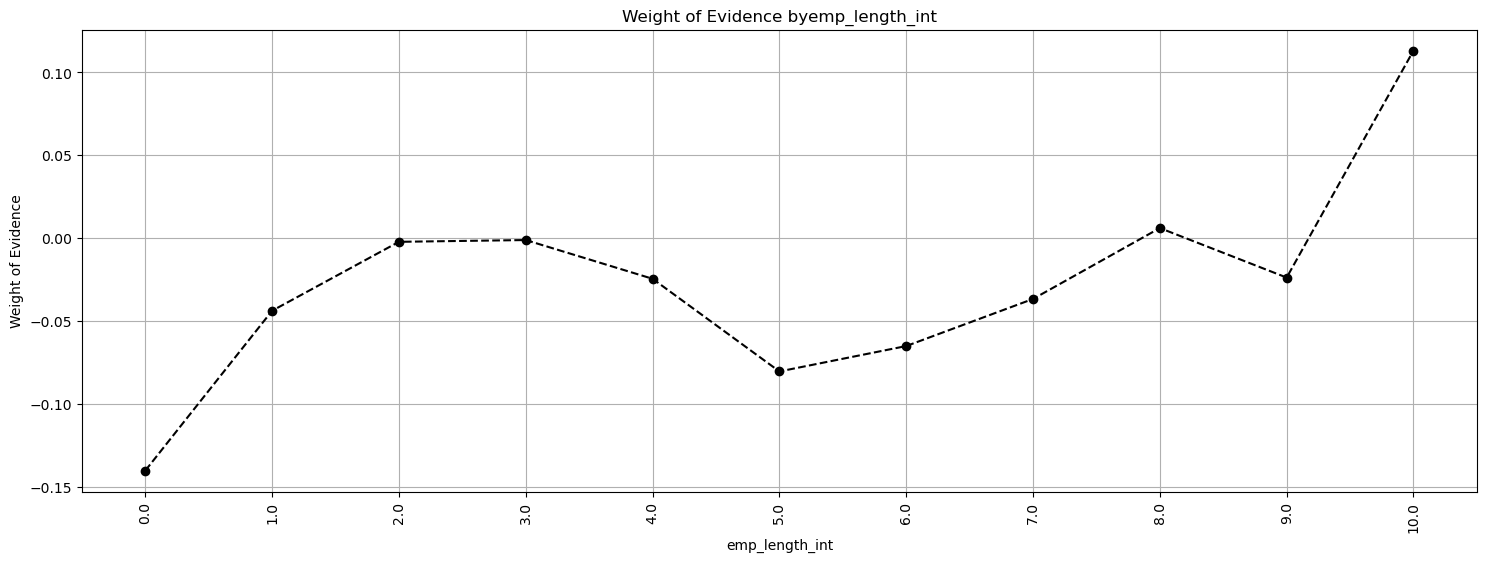

In [28]:
plot_woe(woe_ordered_continuous(X_train_pd, 'emp_length_int', y_train_pd), 90)

In [29]:
train_temp = X_train_pd.copy()
test_temp = y_train_pd.copy()

In [30]:
train_temp['mths_since_issue_date_factor'] = pd.cut(train_temp['mths_since_issue_date'], 50)
woe_ordered_continuous(train_temp, 'mths_since_issue_date_factor', test_temp)

,mths_since_issue_date_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(-0.653, 13.06]",24,0.875000,0.000064,21.0,3.0,0.000062,0.000083,-0.282799,0.016789,NaN,NaN
1,"(13.06, 26.12]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
2,"(26.12, 39.18]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
3,"(39.18, 52.24]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
4,"(52.24, 65.3]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
5,"(65.3, 78.36]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
6,"(78.36, 91.42]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
7,"(91.42, 104.48]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
8,"(104.48, 117.54]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
9,"(117.54, 130.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN


In [31]:
train_temp['int_rate_factor'] = pd.cut(train_temp['int_rate'], 50)
woe_ordered_continuous(train_temp, 'int_rate_factor', test_temp)

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(5.399, 5.833]",785,0.961783,0.002104,755.0,30.0,0.002242,0.000827,0.996811,0.345435,NaN,NaN
1,"(5.833, 6.246]",8459,0.982149,0.022677,8308.0,151.0,0.024670,0.004164,1.778985,0.345435,0.020366,0.782174
2,"(6.246, 6.658]",7826,0.974572,0.020980,7627.0,199.0,0.022648,0.005488,1.417435,0.345435,0.007577,0.361549
3,"(6.658, 7.071]",1816,0.974119,0.004868,1769.0,47.0,0.005253,0.001296,1.399312,0.345435,0.000453,0.018123
4,"(7.071, 7.484]",3143,0.980274,0.008426,3081.0,62.0,0.009149,0.001710,1.677166,0.345435,0.006155,0.277853
5,"(7.484, 7.897]",12581,0.966219,0.033727,12156.0,425.0,0.036096,0.011721,1.124779,0.345435,0.014055,0.552386
6,"(7.897, 8.31]",9687,0.954062,0.025969,9242.0,445.0,0.027443,0.012273,0.804730,0.345435,0.012157,0.320050
7,"(8.31, 8.722]",6594,0.973612,0.017677,6420.0,174.0,0.019064,0.004799,1.379408,0.345435,0.019550,0.574679
8,"(8.722, 9.135]",9539,0.940979,0.025572,8976.0,563.0,0.026653,0.015527,0.540320,0.345435,0.032633,0.839088
9,"(9.135, 9.548]",6681,0.971711,0.017910,6492.0,189.0,0.019277,0.005212,1.307869,0.345435,0.030732,0.767549


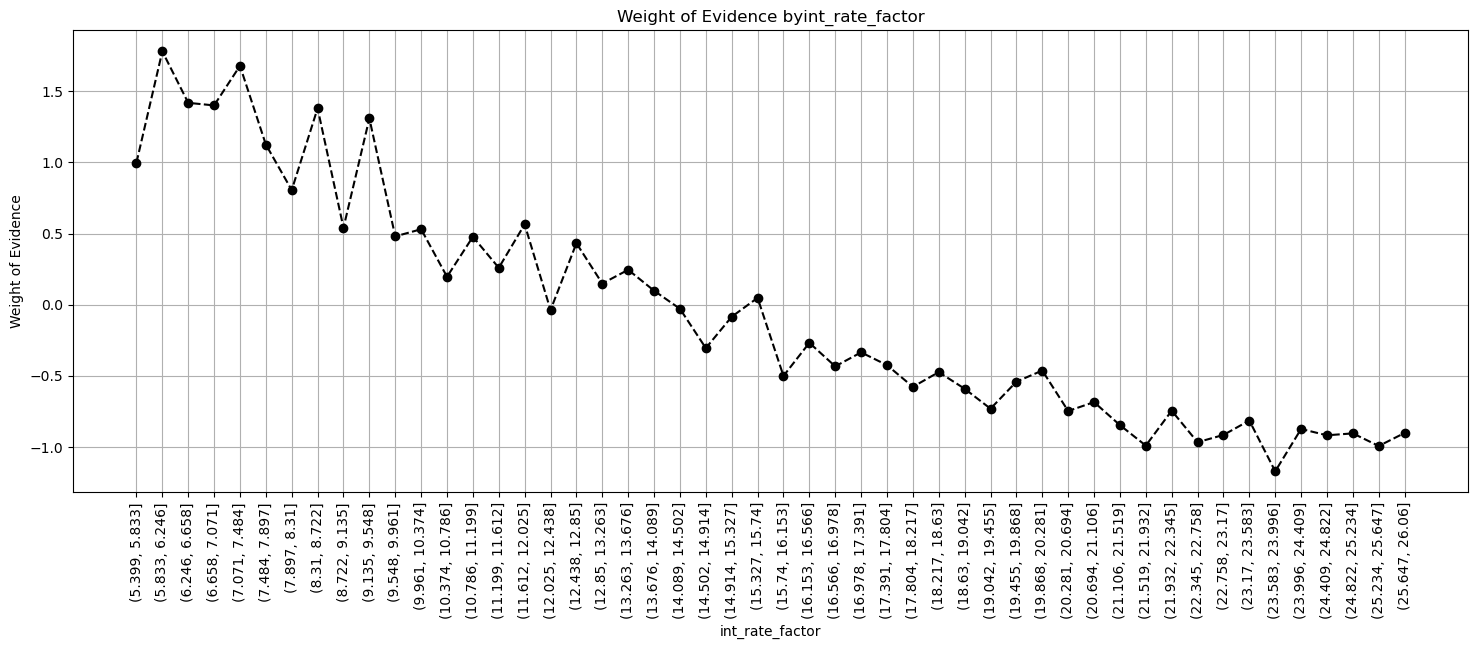

In [32]:
plot_woe(woe_ordered_continuous(train_temp, 'int_rate_factor', test_temp), 90)

In [33]:
train_temp['funded_amnt_factor'] = pd.cut(train_temp['funded_amnt'], 50)
woe_ordered_continuous(train_temp, 'funded_amnt_factor', test_temp)

,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(465.5, 1190.0]",1224,0.913399,0.003281,1118.0,106.0,0.003320,0.002923,0.127148,0.014711,NaN,NaN
1,"(1190.0, 1880.0]",3028,0.908520,0.008117,2751.0,277.0,0.008169,0.007639,0.066993,0.014711,0.004878,0.060155
2,"(1880.0, 2570.0]",6018,0.899634,0.016133,5414.0,604.0,0.016076,0.016658,-0.035540,0.014711,0.008886,0.102533
3,"(2570.0, 3260.0]",7248,0.895695,0.019430,6492.0,756.0,0.019277,0.020850,-0.078425,0.014711,0.003939,0.042885
4,"(3260.0, 3950.0]",4751,0.896864,0.012736,4261.0,490.0,0.012653,0.013514,-0.065856,0.014711,0.001168,0.012569
5,"(3950.0, 4640.0]",9023,0.898703,0.024189,8109.0,914.0,0.024079,0.025208,-0.045810,0.014711,0.001839,0.020046
6,"(4640.0, 5330.0]",15903,0.902471,0.042632,14352.0,1551.0,0.042617,0.042776,-0.003720,0.014711,0.003768,0.042090
7,"(5330.0, 6020.0]",17236,0.914307,0.046206,15759.0,1477.0,0.046795,0.040735,0.138689,0.014711,0.011836,0.142409
8,"(6020.0, 6710.0]",6914,0.896731,0.018535,6200.0,714.0,0.018410,0.019692,-0.067288,0.014711,0.017576,0.205977
9,"(6710.0, 7400.0]",11806,0.910300,0.031649,10747.0,1059.0,0.031912,0.029207,0.088592,0.014711,0.013569,0.155880


In [34]:
train_temp['mths_since_earliest_cr_line_factor'] = pd.cut(train_temp['mths_since_earliest_cr_line'], 50)
woe_ordered_continuous(train_temp, 'mths_since_earliest_cr_line_factor', test_temp)

,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(-0.653, 13.06]",24,0.875000,0.000064,21.0,3.0,0.000062,0.000083,-0.282799,0.016789,NaN,NaN
1,"(13.06, 26.12]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
2,"(26.12, 39.18]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
3,"(39.18, 52.24]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
4,"(52.24, 65.3]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
5,"(65.3, 78.36]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
6,"(78.36, 91.42]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
7,"(91.42, 104.48]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
8,"(104.48, 117.54]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN
9,"(117.54, 130.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.016789,NaN,NaN


In [35]:
train_temp['installment_factor'] = pd.cut(train_temp['installment'], 50)
woe_ordered_continuous(train_temp, 'installment_factor', test_temp)

,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(14.276, 43.556]",1812,0.911700,0.004858,1652.0,160.0,0.004905,0.004413,0.105859,0.013047,NaN,NaN
1,"(43.556, 71.443]",4841,0.902913,0.012978,4371.0,470.0,0.012979,0.012962,0.001305,0.013047,8.787158e-03,0.104554
2,"(71.443, 99.329]",6824,0.898007,0.018294,6128.0,696.0,0.018196,0.019195,-0.053436,0.013047,4.905587e-03,0.054740
3,"(99.329, 127.216]",9138,0.895820,0.024497,8186.0,952.0,0.024307,0.026256,-0.077094,0.013047,2.187380e-03,0.023658
4,"(127.216, 155.102]",10040,0.902789,0.026915,9064.0,976.0,0.026915,0.026917,-0.000106,0.013047,6.969190e-03,0.076988
5,"(155.102, 182.988]",16816,0.904912,0.045080,15217.0,1599.0,0.045185,0.044099,0.024325,0.013047,2.123144e-03,0.024432
6,"(182.988, 210.875]",17216,0.912465,0.046152,15709.0,1507.0,0.046646,0.041562,0.115403,0.013047,7.553160e-03,0.091078
7,"(210.875, 238.761]",15090,0.910338,0.040453,13737.0,1353.0,0.040791,0.037315,0.089059,0.013047,2.127177e-03,0.026344
8,"(238.761, 266.648]",18842,0.913650,0.050511,17215.0,1627.0,0.051118,0.044872,0.130334,0.013047,3.312383e-03,0.041275
9,"(266.648, 294.534]",20100,0.905075,0.053883,18192.0,1908.0,0.054019,0.052621,0.026217,0.013047,8.575729e-03,0.104117


In [36]:
train_temp['delinq_2yrs_factor'] = pd.cut(train_temp['delinq_2yrs'].loc[train_temp.delinq_2yrs < 1], 10)
woe_ordered_continuous(train_temp, 'delinq_2yrs_factor', test_temp)

,delinq_2yrs_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(-0.001, -0.0008]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,"(-0.0008, -0.0006]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,"(-0.0006, -0.0004]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,"(-0.0004, -0.0002]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,"(-0.0002, 0.0]",306417,0.90212,1.0,276425.0,29992.0,1.0,1.0,0.0,0.0,NaN,NaN
5,"(0.0, 0.0002]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
6,"(0.0002, 0.0004]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
7,"(0.0004, 0.0006]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
8,"(0.0006, 0.0008]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
9,"(0.0008, 0.001]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


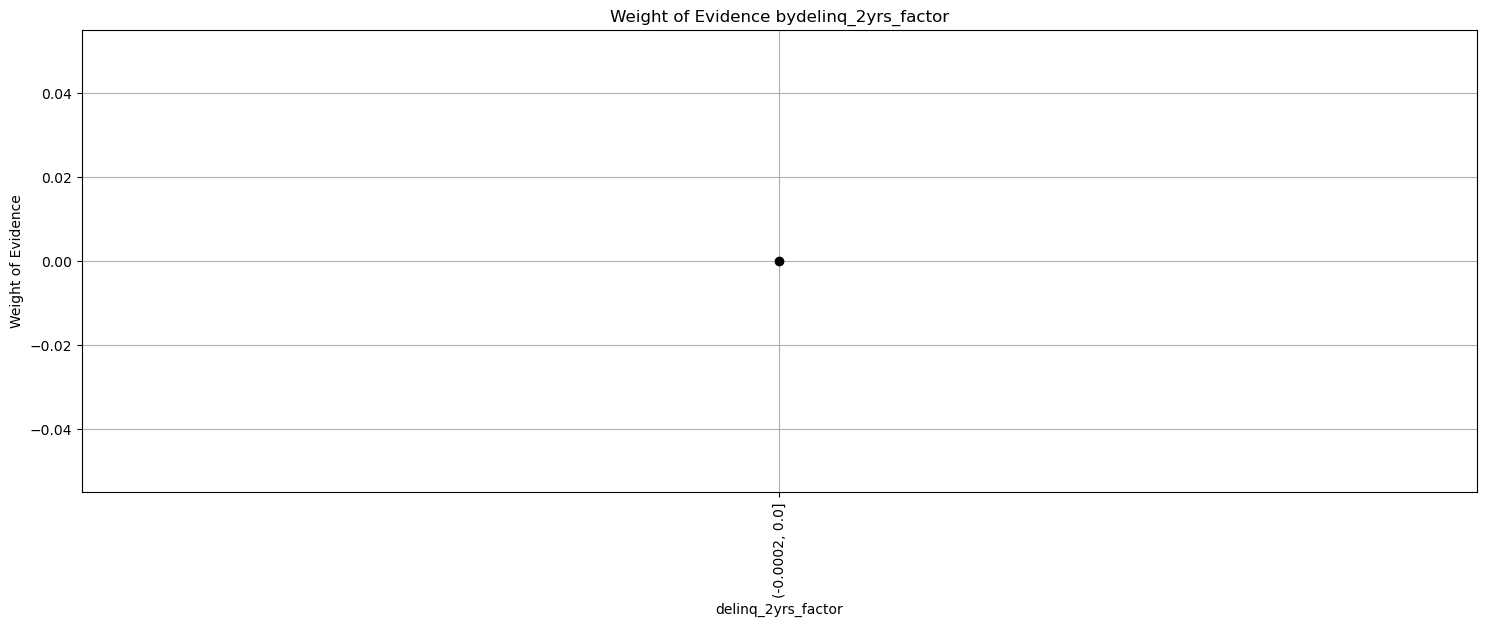

In [37]:
plot_woe(woe_ordered_continuous(train_temp, 'delinq_2yrs_factor', test_temp), 90)

In [38]:
train_temp['inq_last_6mths_factor'] = pd.cut(train_temp['inq_last_6mths'], 50)
woe_ordered_continuous(train_temp, 'inq_last_6mths_factor', test_temp)

,inq_last_6mths_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(-0.033, 0.66]",193232,0.919511,0.518009,177679.0,15553.0,0.527599,0.428942,0.207015,inf,NaN,NaN
1,"(0.66, 1.32]",104163,0.897804,0.279236,93518.0,10645.0,0.277692,0.293582,-0.055646,inf,0.021707,0.262661
2,"(1.32, 1.98]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
3,"(1.98, 2.64]",46214,0.877786,0.123889,40566.0,5648.0,0.120456,0.155768,-0.257081,inf,NaN,NaN
4,"(2.64, 3.3]",20040,0.853543,0.053723,17105.0,2935.0,0.050791,0.080945,-0.466046,inf,0.024243,0.208965
5,"(3.3, 3.96]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
6,"(3.96, 4.62]",5810,0.861790,0.015575,5007.0,803.0,0.014868,0.022146,-0.398472,inf,NaN,NaN
7,"(4.62, 5.28]",2217,0.839874,0.005943,1862.0,355.0,0.005529,0.009791,-0.571421,inf,0.021916,0.172949
8,"(5.28, 5.94]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
9,"(5.94, 6.6]",977,0.803480,0.002619,785.0,192.0,0.002331,0.005295,-0.820521,inf,NaN,NaN


In [39]:
train_temp['inq_last_6mths'].value_counts()

0.0     193232
1.0     104163
2.0      46214
3.0      20040
4.0       5810
5.0       2217
6.0        977
7.0        159
8.0        101
9.0         43
10.0        17
12.0        12
15.0         9
11.0         8
13.0         5
14.0         5
16.0         3
17.0         2
18.0         2
28.0         1
20.0         1
24.0         1
33.0         1
31.0         1
19.0         1
25.0         1
27.0         1
32.0         1
Name: inq_last_6mths, dtype: int64

In [40]:
train_temp['open_acc_factor'] = pd.cut(train_temp['open_acc'], 50)
woe_ordered_continuous(train_temp, 'open_acc_factor', test_temp)

,open_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(-0.084, 1.68]",139,0.856115,0.000373,119.0,20.0,0.000353,0.000552,-0.445318,inf,NaN,NaN
1,"(1.68, 3.36]",5834,0.874529,0.015640,5102.0,732.0,0.015150,0.020188,-0.287102,inf,0.018414,0.158216
2,"(3.36, 5.04]",27169,0.900217,0.072834,24458.0,2711.0,0.072625,0.074768,-0.029070,inf,0.025689,0.258032
3,"(5.04, 6.72]",24621,0.902157,0.066003,22212.0,2409.0,0.065956,0.066439,-0.007289,inf,0.001940,0.021781
4,"(6.72, 8.4]",63748,0.902444,0.170893,57529.0,6219.0,0.170826,0.171516,-0.004030,inf,0.000287,0.003259
5,"(8.4, 10.08]",69187,0.902250,0.185474,62424.0,6763.0,0.185361,0.186519,-0.006226,inf,0.000194,0.002197
6,"(10.08, 11.76]",31372,0.898508,0.084101,28188.0,3184.0,0.083701,0.087813,-0.047952,inf,0.003742,0.041725
7,"(11.76, 13.44]",51591,0.904286,0.138303,46653.0,4938.0,0.138531,0.136187,0.017067,inf,0.005777,0.065019
8,"(13.44, 15.12]",35998,0.903967,0.096502,32541.0,3457.0,0.096627,0.095342,0.013390,inf,0.000319,0.003677
9,"(15.12, 16.8]",13540,0.907607,0.036298,12289.0,1251.0,0.036491,0.034502,0.056052,inf,0.003640,0.042662


In [41]:
train_temp['pub_rec_factor'] = pd.cut(train_temp['pub_rec'], 50)
woe_ordered_continuous(train_temp, 'pub_rec_factor', test_temp)

,pub_rec_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(-0.063, 1.26]",366380,0.902437,0.982178,330635.0,35745.0,0.981786,0.985824,-0.004105,inf,NaN,NaN
1,"(1.26, 2.52]",4527,0.915617,0.012136,4145.0,382.0,0.012308,0.010535,0.155528,inf,0.013180,0.159633
2,"(2.52, 3.78]",1280,0.938281,0.003431,1201.0,79.0,0.003566,0.002179,0.492752,inf,0.022664,0.337225
3,"(3.78, 5.04]",611,0.932897,0.001638,570.0,41.0,0.001693,0.001131,0.403355,inf,0.005384,0.089398
4,"(5.04, 6.3]",117,0.931624,0.000314,109.0,8.0,0.000324,0.000221,0.383197,inf,0.001273,0.020158
5,"(6.3, 7.56]",48,0.958333,0.000129,46.0,2.0,0.000137,0.000055,0.906785,inf,0.026709,0.523588
6,"(7.56, 8.82]",24,1.000000,0.000064,24.0,0.0,0.000071,0.000000,inf,inf,0.041667,inf
7,"(8.82, 10.08]",24,0.916667,0.000064,22.0,2.0,0.000065,0.000055,0.169186,inf,0.083333,inf
8,"(10.08, 11.34]",3,1.000000,0.000008,3.0,0.0,0.000009,0.000000,inf,inf,0.083333,inf
9,"(11.34, 12.6]",1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf,0.000000,NaN


In [42]:
train_temp['pub_rec'].value_counts()

0.0     323999
1.0      42381
2.0       4527
3.0       1280
4.0        408
5.0        203
6.0        117
7.0         48
8.0         24
9.0         14
10.0        10
11.0         3
13.0         2
18.0         2
40.0         1
63.0         1
15.0         1
54.0         1
19.0         1
12.0         1
16.0         1
34.0         1
17.0         1
21.0         1
Name: pub_rec, dtype: int64

In [43]:
train_temp['acc_now_delinq_factor'] = pd.cut(train_temp['acc_now_delinq'], 50)
woe_ordered_continuous(train_temp, 'acc_now_delinq_factor', test_temp)

,acc_now_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(-0.005, 0.1]",371682,0.902761,0.996392,335540.0,36142.0,0.996351,0.996773,-0.000424,inf,NaN,NaN
1,"(0.1, 0.2]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
2,"(0.2, 0.3]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
3,"(0.3, 0.4]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
4,"(0.4, 0.5]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
5,"(0.5, 0.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
6,"(0.6, 0.7]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
7,"(0.7, 0.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
8,"(0.8, 0.9]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
9,"(0.9, 1.0]",1263,0.912114,0.003386,1152.0,111.0,0.003421,0.003061,0.111015,inf,NaN,NaN


In [44]:
train_temp['acc_now_delinq'].value_counts()

0.0    371682
1.0      1263
2.0        70
3.0         7
4.0         4
5.0         2
Name: acc_now_delinq, dtype: int64

In [45]:
train_temp['annual_inc_factor'] = pd.cut(train_temp['annual_inc'].loc[train_temp.annual_inc < 144000], 50)
woe_ordered_continuous(train_temp, 'annual_inc_factor', test_temp)

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(1753.915, 4737.7]",15,0.800000,0.000043,12.0,3.0,0.000038,0.000086,-0.820404,0.05365,NaN,NaN
1,"(4737.7, 7579.4]",45,0.777778,0.000128,35.0,10.0,0.000110,0.000287,-0.953936,0.05365,0.022222,0.133531
2,"(7579.4, 10421.1]",307,0.882736,0.000873,271.0,36.0,0.000855,0.001033,-0.188099,0.05365,0.104958,0.765837
3,"(10421.1, 13262.8]",681,0.841410,0.001937,573.0,108.0,0.001809,0.003098,-0.537944,0.05365,0.041326,0.349845
4,"(13262.8, 16104.5]",1323,0.848073,0.003762,1122.0,201.0,0.003542,0.005765,-0.487135,0.05365,0.006663,0.050809
5,"(16104.5, 18946.2]",1421,0.857143,0.004041,1218.0,203.0,0.003845,0.005822,-0.414939,0.05365,0.009070,0.072196
6,"(18946.2, 21787.9]",3065,0.864600,0.008716,2650.0,415.0,0.008365,0.011903,-0.352662,0.05365,0.007457,0.062277
7,"(21787.9, 24629.6]",4059,0.866223,0.011543,3516.0,543.0,0.011099,0.015574,-0.338729,0.05365,0.001623,0.013934
8,"(24629.6, 27471.3]",6598,0.863747,0.018763,5699.0,899.0,0.017990,0.025784,-0.359936,0.05365,0.002477,0.021207
9,"(27471.3, 30313.0]",10650,0.876056,0.030286,9330.0,1320.0,0.029453,0.037859,-0.251095,0.05365,0.012310,0.108840


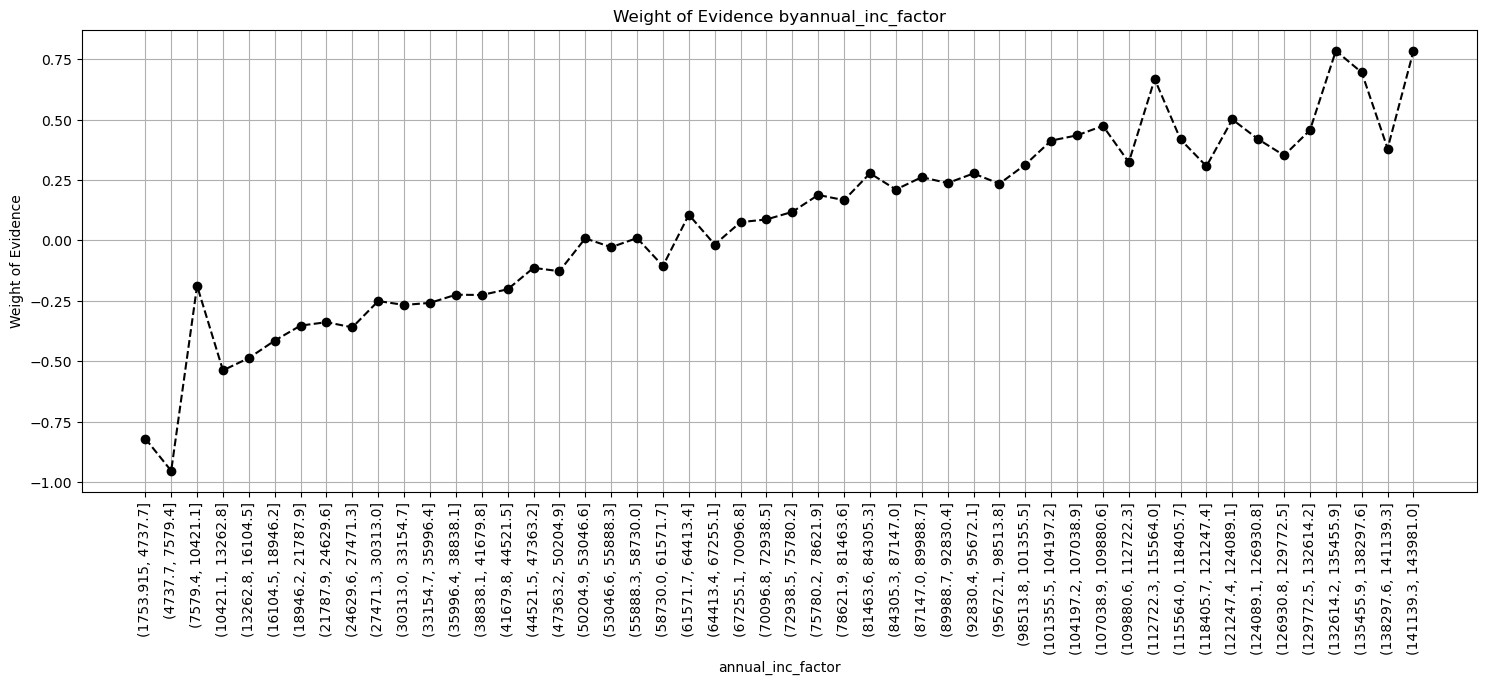

In [46]:
plot_woe(woe_ordered_continuous(train_temp, 'annual_inc_factor', test_temp), 90)

In [47]:
train_temp['mths_since_last_delinq_factor'] = pd.cut(train_temp['mths_since_last_delinq'], 50)
woe_ordered_continuous(train_temp, 'mths_since_last_delinq_factor', test_temp)

,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(-0.188, 3.76]",205462,0.899709,0.550795,184856.0,20606.0,0.548910,0.568300,-0.034715,inf,NaN,NaN
1,"(3.76, 7.52]",11167,0.902928,0.029936,10083.0,1084.0,0.029940,0.029896,0.001483,inf,0.003219,0.036198
2,"(7.52, 11.28]",13306,0.908237,0.035670,12085.0,1221.0,0.035885,0.033674,0.063585,inf,0.005309,0.062102
3,"(11.28, 15.04]",13216,0.903223,0.035429,11937.0,1279.0,0.035446,0.035274,0.004855,inf,0.005014,0.058731
4,"(15.04, 18.8]",9337,0.907786,0.025030,8476.0,861.0,0.025169,0.023746,0.058190,inf,0.004563,0.053335
5,"(18.8, 22.56]",11641,0.906623,0.031207,10554.0,1087.0,0.031339,0.029979,0.044374,inf,0.001163,0.013816
6,"(22.56, 26.32]",10887,0.908698,0.029185,9893.0,994.0,0.029376,0.027414,0.069136,inf,0.002075,0.024762
7,"(26.32, 30.08]",10560,0.907197,0.028309,9580.0,980.0,0.028447,0.027028,0.051171,inf,0.001501,0.017965
8,"(30.08, 33.84]",7576,0.914203,0.020309,6926.0,650.0,0.020566,0.017927,0.137356,inf,0.007006,0.086185
9,"(33.84, 37.6]",9795,0.910873,0.026258,8922.0,873.0,0.026493,0.024077,0.095630,inf,0.003330,0.041726


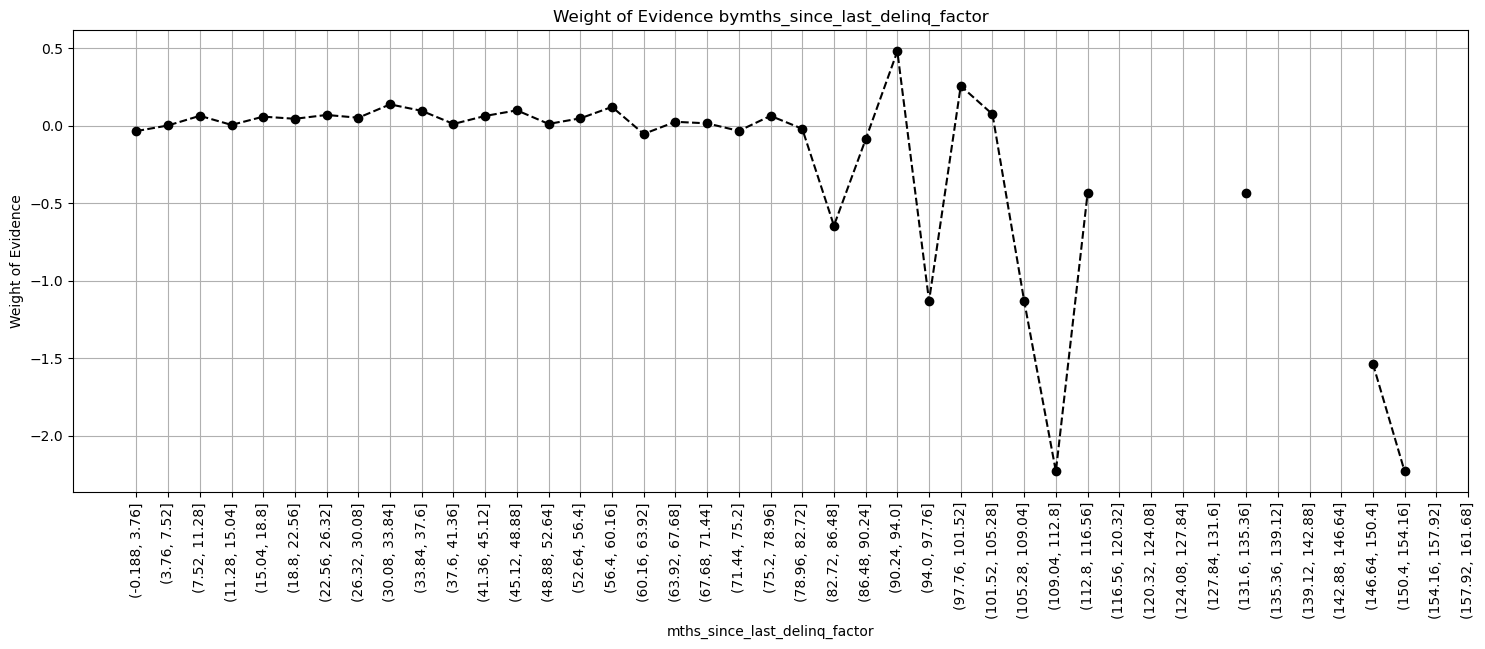

In [48]:
plot_woe(woe_ordered_continuous(train_temp, 'mths_since_last_delinq_factor', test_temp), 90)

In [49]:
train_temp['dti_factor'] = pd.cut(train_temp['dti'], 50)
woe_ordered_continuous(train_temp, 'dti_factor', test_temp)

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(-0.04, 0.8]",1553,0.902125,0.004163,1401.0,152.0,0.004160,0.004192,-0.007649,0.023004,NaN,NaN
1,"(0.8, 1.6]",1965,0.901781,0.005268,1772.0,193.0,0.005262,0.005323,-0.011536,0.023004,0.000344,0.003887
2,"(1.6, 2.399]",2509,0.915106,0.006726,2296.0,213.0,0.006818,0.005874,0.148922,0.023004,0.013324,0.160458
3,"(2.399, 3.199]",3234,0.917440,0.008670,2967.0,267.0,0.008810,0.007364,0.179348,0.023004,0.002334,0.030426
4,"(3.199, 3.999]",4124,0.917071,0.011055,3782.0,342.0,0.011230,0.009432,0.174488,0.023004,0.000369,0.004860
5,"(3.999, 4.799]",5037,0.923367,0.013503,4651.0,386.0,0.013811,0.010646,0.260291,0.023004,0.006296,0.085803
6,"(4.799, 5.599]",5989,0.917348,0.016055,5494.0,495.0,0.016314,0.013652,0.178144,0.023004,0.006019,0.082146
7,"(5.599, 6.398]",6781,0.924790,0.018178,6271.0,510.0,0.018621,0.014065,0.280571,0.023004,0.007441,0.102426
8,"(6.398, 7.198]",7665,0.920287,0.020548,7054.0,611.0,0.020946,0.016851,0.217544,0.023004,0.004503,0.063027
9,"(7.198, 7.998]",8747,0.923059,0.023449,8074.0,673.0,0.023975,0.018561,0.255949,0.023004,0.002772,0.038406


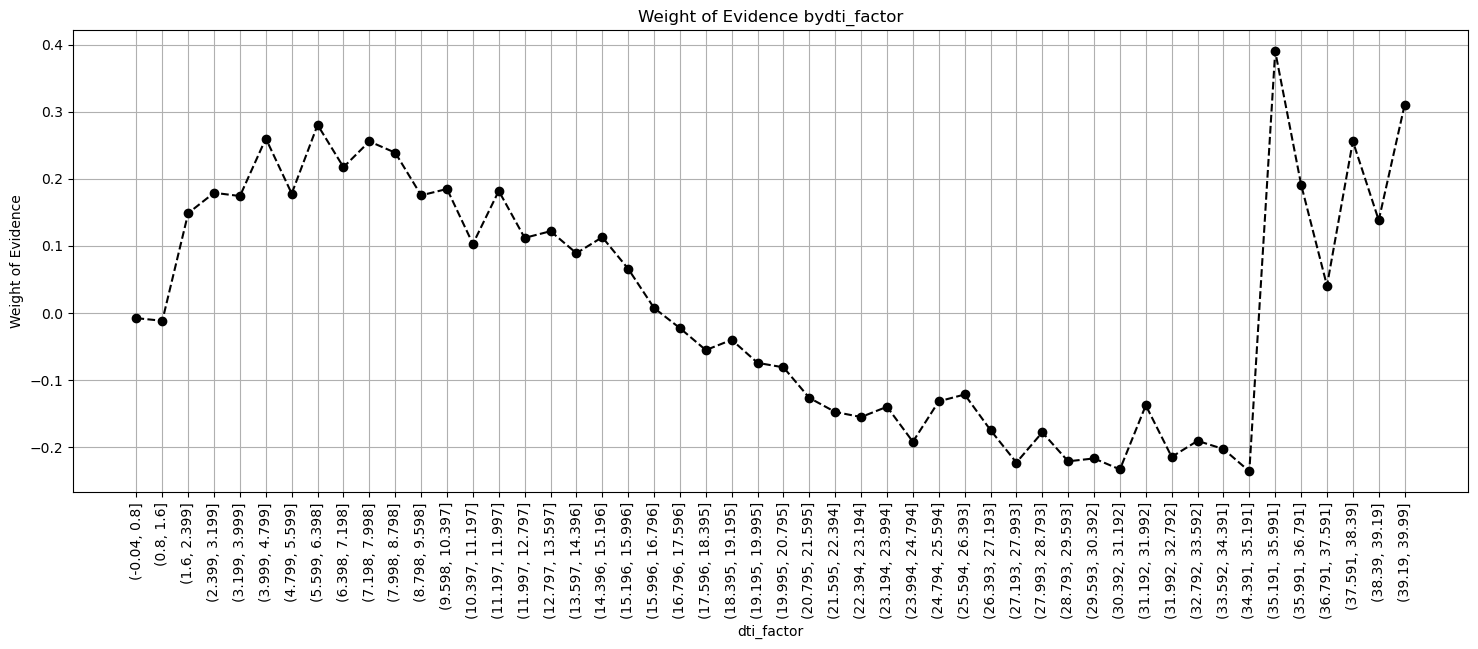

In [50]:
plot_woe(woe_ordered_continuous(train_temp, 'dti_factor', test_temp), 90)

In [51]:
train_temp['mths_since_last_record_factor'] = pd.cut(train_temp['mths_since_last_record'], 50)
woe_ordered_continuous(train_temp, 'mths_since_last_record_factor', test_temp)

,mths_since_last_record_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prcnt_good,prcnt_bad,woe,IV,diff_prop_good,diff_woe
0,"(-0.121, 2.42]",324047,0.901665,0.868694,292182.0,31865.0,0.867604,0.878816,-0.012841,0.010336,NaN,NaN
1,"(2.42, 4.84]",76,0.921053,0.000204,70.0,6.0,0.000208,0.000165,0.228026,0.010336,0.019387,0.240867
2,"(4.84, 7.26]",163,0.938650,0.000437,153.0,10.0,0.000454,0.000276,0.499143,0.010336,0.017598,0.271117
3,"(7.26, 9.68]",156,0.929487,0.000418,145.0,11.0,0.000431,0.000303,0.350129,0.010336,0.009163,0.149014
4,"(9.68, 12.1]",292,0.924658,0.000783,270.0,22.0,0.000802,0.000607,0.278670,0.010336,0.004830,0.071459
5,"(12.1, 14.52]",207,0.932367,0.000555,193.0,14.0,0.000573,0.000386,0.394923,0.010336,0.007710,0.116253
6,"(14.52, 16.94]",210,0.942857,0.000563,198.0,12.0,0.000588,0.000331,0.574651,0.010336,0.010490,0.179728
7,"(16.94, 19.36]",334,0.916168,0.000895,306.0,28.0,0.000909,0.000772,0.162671,0.010336,0.026689,0.411980
8,"(19.36, 21.78]",283,0.932862,0.000759,264.0,19.0,0.000784,0.000524,0.402801,0.010336,0.016695,0.240130
9,"(21.78, 24.2]",455,0.916484,0.001220,417.0,38.0,0.001238,0.001048,0.166790,0.010336,0.016379,0.236010


## Feature Extraction - Numerical Features

The following are the selected feature with the **IV** score **> 0.02**:
1. term_int
2. int_rate
3. delinq_2yrs_factor
4. inq_last_6mths
5. open_acc
6. pub_rec
7. acc_now_delinq
8. annual_inc
9. mths_since_last_delinq
10. dti

In [52]:
#term_int
X_train_pd['term_int:36'] = np.where(X_train_pd['term_int']==36, 1, 0)
X_train_pd['term_int:60'] = np.where(X_train_pd['term_int']==60, 1, 0)

X_test_pd['term_int:36'] = np.where(X_test_pd['term_int']==36, 1, 0)
X_test_pd['term_int:60'] = np.where(X_test_pd['term_int']==60, 1, 0)

In [53]:
#int_rate
X_train_pd['int_rate:<=10'] = np.where(X_train_pd['int_rate']<=10, 1, 0)
X_train_pd['int_rate:10-15'] = np.where((X_train_pd['int_rate']>10) & (X_train_pd['int_rate']<=15), 1, 0)
X_train_pd['int_rate:15-20'] = np.where((X_train_pd['int_rate']>15) & (X_train_pd['int_rate']<=20), 1, 0)
X_train_pd['int_rate:>=20'] = np.where(X_train_pd['int_rate']>20, 1, 0)

X_test_pd['int_rate:<=10'] = np.where(X_test_pd['int_rate']<=10, 1, 0)
X_test_pd['int_rate:10-15'] = np.where((X_test_pd['int_rate']>10) & (X_test_pd['int_rate']<=15), 1, 0)
X_test_pd['int_rate:15-20'] = np.where((X_test_pd['int_rate']>15) & (X_test_pd['int_rate']<=20), 1, 0)
X_test_pd['int_rate:>=20'] = np.where(X_test_pd['int_rate']>20, 1, 0)


In [54]:
#delinq_2yrs
X_train_pd['delinq_2yrs:<=1'] = np.where(X_train_pd['delinq_2yrs']<=1, 1, 0)
X_train_pd['delinq_2yrs:>1'] = np.where(X_train_pd['delinq_2yrs']>1, 1, 0)

X_test_pd['delinq_2yrs:<=1'] = np.where(X_test_pd['delinq_2yrs']<=1, 1, 0)
X_test_pd['delinq_2yrs:>1'] = np.where(X_test_pd['delinq_2yrs']>1, 1, 0)

In [55]:
X_train_pd[['delinq_2yrs', 'delinq_2yrs:<=1', 'delinq_2yrs:>1']].sample(10)

,delinq_2yrs,delinq_2yrs:<=1,delinq_2yrs:>1
343331,0.0,1,0
164660,0.0,1,0
245973,0.0,1,0
172564,0.0,1,0
144199,0.0,1,0
341269,0.0,1,0
10541,0.0,1,0
326703,0.0,1,0
275031,0.0,1,0
167611,0.0,1,0


In [56]:
#inq_last_6mths
X_train_pd['inq_last_6mths:<=1'] = np.where(X_train_pd['inq_last_6mths']<=1, 1, 0)
X_train_pd['inq_last_6mths:>1'] = np.where(X_train_pd['inq_last_6mths']>1, 1, 0)

X_test_pd['inq_last_6mths:<=1'] = np.where(X_test_pd['inq_last_6mths']<=1, 1, 0)
X_test_pd['inq_last_6mths:>1'] = np.where(X_test_pd['inq_last_6mths']>1, 1, 0)

In [57]:
#open_acc
X_train_pd['open_acc:<=8'] = np.where(X_train_pd['open_acc']<=8, 1, 0)
X_train_pd['open_acc:8-14'] = np.where((X_train_pd['open_acc']>8) & (X_train_pd['open_acc']<=14), 1, 0)
X_train_pd['open_acc:>14'] = np.where(X_train_pd['open_acc']>14, 1, 0)

X_test_pd['open_acc:<=8'] = np.where(X_test_pd['open_acc']<=8, 1, 0)
X_test_pd['open_acc:8-14'] = np.where((X_test_pd['open_acc']>8) & (X_test_pd['open_acc']<=14), 1, 0)
X_test_pd['open_acc:>14'] = np.where(X_test_pd['open_acc']>14, 1, 0)

In [58]:
#pub_rec
X_train_pd['pub_rec:<=1'] = np.where(X_train_pd['pub_rec']<=1, 1, 0)
X_train_pd['pub_rec:>1'] = np.where(X_train_pd['pub_rec']>1, 1, 0)

X_test_pd['pub_rec:<=1'] = np.where(X_test_pd['pub_rec']<=1, 1, 0)
X_test_pd['pub_rec:>1'] = np.where(X_test_pd['pub_rec']>1, 1, 0)

In [59]:
#annual_inc
X_train_pd['annual_inc:<20k'] = np.where(X_train_pd['annual_inc'] < 20000, 1, 0)
X_train_pd['annual_inc:20k-30k'] = np.where(
    ((X_train_pd['annual_inc']>=20000) & (X_train_pd['annual_inc']<30000)), 1, 0
)

X_train_pd['annual_inc:30k-40k'] = np.where(
     ((X_train_pd['annual_inc']>=30000) & (X_train_pd['annual_inc']<40000)), 1, 0
)

X_train_pd['annual_inc:40k-50k'] = np.where(
     ((X_train_pd['annual_inc']>=40000) & (X_train_pd['annual_inc']<50000)), 1, 0
)

X_train_pd['annual_inc:50k-60k'] = np.where(
    ((X_train_pd['annual_inc']>=50000) & (X_train_pd['annual_inc']<60000)), 1, 0
)

X_train_pd['annual_inc:60k-70k'] = np.where(
     ((X_train_pd['annual_inc']>=60000) & (X_train_pd['annual_inc']<70000)), 1, 0
)

X_train_pd['annual_inc:70k-80k'] = np.where(
    ((X_train_pd['annual_inc']>=70000) & (X_train_pd['annual_inc']<80000)), 1, 0
)

X_train_pd['annual_inc:80k-90k'] = np.where(
     ((X_train_pd['annual_inc']>=80000) & (X_train_pd['annual_inc']<90000)), 1, 0
)

X_train_pd['annual_inc:90k-100k'] = np.where(
     ((X_train_pd['annual_inc']>=90000) & (X_train_pd['annual_inc']<100000)), 1, 0
)

X_train_pd['annual_inc:100k-120k'] = np.where(
     ((X_train_pd['annual_inc']>=100000) & (X_train_pd['annual_inc']<120000)), 1, 0
)

X_train_pd['annual_inc:120k-140k'] = np.where(
     ((X_train_pd['annual_inc']>=120000) & (X_train_pd['annual_inc']<140000)), 1, 0
)

X_train_pd['annual_inc:>140k'] = np.where(X_train_pd['annual_inc'] >= 140000, 1, 0)

In [60]:
#annual_inc
X_test_pd['annual_inc:<20k'] = np.where(X_test_pd['annual_inc'] < 20000, 1, 0)
X_test_pd['annual_inc:20k-30k'] = np.where(
    ((X_test_pd['annual_inc']>=20000) & (X_test_pd['annual_inc']<30000)), 1, 0
)

X_test_pd['annual_inc:30k-40k'] = np.where(
     ((X_test_pd['annual_inc']>=30000) & (X_test_pd['annual_inc']<40000)), 1, 0
)

X_test_pd['annual_inc:40k-50k'] = np.where(
     ((X_test_pd['annual_inc']>=40000) & (X_test_pd['annual_inc']<50000)), 1, 0
)

X_test_pd['annual_inc:50k-60k'] = np.where(
    ((X_test_pd['annual_inc']>=50000) & (X_test_pd['annual_inc']<60000)), 1, 0
)

X_test_pd['annual_inc:60k-70k'] = np.where(
     ((X_test_pd['annual_inc']>=60000) & (X_test_pd['annual_inc']<70000)), 1, 0
)

X_test_pd['annual_inc:70k-80k'] = np.where(
    ((X_test_pd['annual_inc']>=70000) & (X_test_pd['annual_inc']<80000)), 1, 0
)

X_test_pd['annual_inc:80k-90k'] = np.where(
     ((X_test_pd['annual_inc']>=80000) & (X_test_pd['annual_inc']<90000)), 1, 0
)

X_test_pd['annual_inc:90k-100k'] = np.where(
     ((X_test_pd['annual_inc']>=90000) & (X_test_pd['annual_inc']<100000)), 1, 0
)

X_test_pd['annual_inc:100k-120k'] = np.where(
     ((X_test_pd['annual_inc']>=100000) & (X_test_pd['annual_inc']<120000)), 1, 0
)

X_test_pd['annual_inc:120k-140k'] = np.where(
     ((X_test_pd['annual_inc']>=120000) & (X_test_pd['annual_inc']<140000)), 1, 0
)

X_test_pd['annual_inc:>140k'] = np.where(X_test_pd['annual_inc'] >= 140000, 1, 0)

In [61]:
#mths_since_last_delinq
X_train_pd['mths_since_last_delinq:<=4'] = np.where(X_train_pd['mths_since_last_delinq']<=4, 1, 0)
X_train_pd['mths_since_last_delinq:4-30'] = np.where((X_train_pd['mths_since_last_delinq']>4) & (X_train_pd['mths_since_last_delinq']<=30), 1, 0)
X_train_pd['mths_since_last_delinq:>30'] = np.where(X_train_pd['mths_since_last_delinq']>30, 1, 0)

X_test_pd['mths_since_last_delinq:<=4'] = np.where(X_test_pd['mths_since_last_delinq']<=4, 1, 0)
X_test_pd['mths_since_last_delinq:4-30'] = np.where((X_test_pd['mths_since_last_delinq']>4) & (X_test_pd['mths_since_last_delinq']<=30), 1, 0)
X_test_pd['mths_since_last_delinq:>30'] = np.where(X_test_pd['mths_since_last_delinq']>30, 1, 0)

In [62]:
#dti
X_train_pd['dti:<=10'] = np.where(X_train_pd['dti']<=10, 1, 0)
X_train_pd['dti:10-15'] = np.where((X_train_pd['dti']>10) & (X_train_pd['dti']<=15), 1, 0)
X_train_pd['dti:15-20'] = np.where((X_train_pd['dti']>15) & (X_train_pd['dti']<=20), 1, 0)
X_train_pd['dti:20-25'] = np.where((X_train_pd['dti']>20) & (X_train_pd['dti']<=25), 1, 0)
X_train_pd['dti:>25'] = np.where(X_train_pd['dti']>25, 1, 0)

X_test_pd['dti:<=10'] = np.where(X_test_pd['dti']<=10, 1, 0)
X_test_pd['dti:10-15'] = np.where((X_test_pd['dti']>10) & (X_test_pd['dti']<=15), 1, 0)
X_test_pd['dti:15-20'] = np.where((X_test_pd['dti']>15) & (X_test_pd['dti']<=20), 1, 0)
X_test_pd['dti:20-25'] = np.where((X_test_pd['dti']>20) & (X_test_pd['dti']<=25), 1, 0)
X_test_pd['dti:>25'] = np.where(X_test_pd['dti']>25, 1, 0)

In [63]:
selected_features= [
    'grade:A','grade:B','grade:C','grade:D','grade:E','grade:F','grade:G',
    'home_ownership:RENT_OTHER_NONE_ANY', 'home_ownership:MORTGAGE', 'home_ownership:OWN',
    'ver_status:Not Verified', 'ver_status:Source Verified', 'ver_status:Verified',
    'purpose:small_business_educational_moving', 'purpose:renewable_energy_other_house', 'purpose:medical_wedding_vacation', 'purpose:debt_consolidation', 'purpose:home_improvement_major_purchase_car', 'purpose:credit_card',
    'adrr_state:NE_IA_NV_FL_AL_NM_HI_MO', 'adrr_state:CA', 'adrr_state:KY_VA', 'adrr_state:NY', 'adrr_state:NC_UT', 'adrr_state:MD_NJ_LA_OK_MI_TN', 'adrr_state:MN_AZ_DE_PA_AR_OH', 'adrr_state:WA_MA_IN_GA_RI_OR', 'adrr_state:WI_SD_CT', 'adrr_state:TX', 'adrr_state:KS_IL_MT', 'adrr_state:CO_SC_VT_AK', 'adrr_state:MS_NH_WY_WV_DC_ME_ID',
    'list_status:f', 'list_status:w',
    
    'term_int:36', 'term_int:60',
    'int_rate:<=10', 'int_rate:10-15', 'int_rate:15-20', 'int_rate:>=20',
    'delinq_2yrs:<=1', 'delinq_2yrs:>1',
    'inq_last_6mths:<=1', 'inq_last_6mths:>1',
    'open_acc:<=8', 'open_acc:8-14', 'open_acc:>14',
    'pub_rec:<=1', 'pub_rec:>1',
    'annual_inc:<20k', 'annual_inc:20k-30k', 'annual_inc:30k-40k', 'annual_inc:40k-50k', 'annual_inc:50k-60k', 'annual_inc:60k-70k', 'annual_inc:70k-80k', 'annual_inc:80k-90k', 'annual_inc:90k-100k', 'annual_inc:100k-120k', 'annual_inc:120k-140k', 'annual_inc:>140k',
    'mths_since_last_delinq:<=4', 'mths_since_last_delinq:4-30', 'mths_since_last_delinq:>30',
    'dti:<=10', 'dti:10-15', 'dti:15-20','dti:20-25', 'dti:>25'
]

In [64]:
selected_dummy_train = X_train_pd[selected_features]
selected_dummy_test = X_test_pd[selected_features]

In [65]:
selected_dummy_train.head(2)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:MORTGAGE,home_ownership:OWN,ver_status:Not Verified,ver_status:Source Verified,ver_status:Verified,purpose:small_business_educational_moving,purpose:renewable_energy_other_house,purpose:medical_wedding_vacation,purpose:debt_consolidation,purpose:home_improvement_major_purchase_car,purpose:credit_card,adrr_state:NE_IA_NV_FL_AL_NM_HI_MO,adrr_state:CA,adrr_state:KY_VA,adrr_state:NY,adrr_state:NC_UT,adrr_state:MD_NJ_LA_OK_MI_TN,adrr_state:MN_AZ_DE_PA_AR_OH,adrr_state:WA_MA_IN_GA_RI_OR,adrr_state:WI_SD_CT,adrr_state:TX,adrr_state:KS_IL_MT,adrr_state:CO_SC_VT_AK,adrr_state:MS_NH_WY_WV_DC_ME_ID,list_status:f,list_status:w,term_int:36,term_int:60,int_rate:<=10,int_rate:10-15,int_rate:15-20,int_rate:>=20,delinq_2yrs:<=1,delinq_2yrs:>1,inq_last_6mths:<=1,inq_last_6mths:>1,open_acc:<=8,open_acc:8-14,open_acc:>14,pub_rec:<=1,pub_rec:>1,annual_inc:<20k,annual_inc:20k-30k,annual_inc:30k-40k,annual_inc:40k-50k,annual_inc:50k-60k,annual_inc:60k-70k,annual_inc:70k-80k,annual_inc:80k-90k,annual_inc:90k-100k,annual_inc:100k-120k,annual_inc:120k-140k,annual_inc:>140k,mths_since_last_delinq:<=4,mths_since_last_delinq:4-30,mths_since_last_delinq:>30,dti:<=10,dti:10-15,dti:15-20,dti:20-25,dti:>25
427211,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
206088,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0


# PD Model Fitting

In [66]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()
reg.fit(selected_dummy_train, y_train_pd)

LogisticRegression()

In [67]:
y_hat_test = reg.predict(selected_dummy_test)
y_hat_test

array([1, 1, 1, ..., 1, 1, 1])

In [68]:
y_hat_test_proba = reg.predict_proba(selected_dummy_test)
y_hat_test_proba

array([[0.10244748, 0.89755252],
       [0.13390914, 0.86609086],
       [0.05955066, 0.94044934],
       ...,
       [0.0258782 , 0.9741218 ],
       [0.04283403, 0.95716597],
       [0.04183275, 0.95816725]])

In [69]:
#let just store the prob_good_borrower value into the y_hat_test_proba variable
y_hat_test_proba = y_hat_test_proba[:][:,1]

In [70]:
data_test_temp = y_test_pd

In [71]:
data_test_temp.shape

(93257,)

In [72]:
y_hat_test_proba.shape

(93257,)

In [73]:
pd.DataFrame(data_test_temp).head()

,good_bad
362514,1
288564,1
213591,1
263083,1
165001,1


In [74]:
pd.DataFrame(y_hat_test_proba).head()

,0
0,0.897553
1,0.866091
2,0.940449
3,0.929387
4,0.970974


In [75]:
data_test_temp.reset_index(drop=True, inplace=True)

frame = [data_test_temp, pd.DataFrame(y_hat_test_proba)]
data_actual_predicted_proba = pd.concat(frame, axis=1)

data_actual_predicted_proba.columns=['data_target_test','y_hat_test_proba']
data_actual_predicted_proba.index = X_test_pd.index

In [76]:
data_actual_predicted_proba.head()

,data_target_test,y_hat_test_proba
362514,1,0.897553
288564,1,0.866091
213591,1,0.940449
263083,1,0.929387
165001,1,0.970974


In [89]:
pd.options.display.max_rows = None
pd.options.display.float_format = "{:,.5f}".format

feature_name = selected_dummy_train.columns.values

summary_table = pd.DataFrame(columns=['Feature Name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)

#Let's insert the intercept score at the first row
summary_table.index = summary_table.index+1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]

#Sorting the summary table by the index
summary_table = summary_table.sort_index()

# summary_table['decimal_p_values'] = summary_table['p_values'].astype(float)
summary_table

,Feature Name,Coefficients
0,Intercept,0.40386
1,grade:A,0.60254
2,grade:B,0.35116
3,grade:C,0.20646
4,grade:D,0.11595
5,grade:E,-0.09691
6,grade:F,-0.33011
7,grade:G,-0.45003
8,home_ownership:RENT_OTHER_NONE_ANY,0.04268
9,home_ownership:MORTGAGE,0.16989


# Model Evaluation

## AUCROC Curve

In [77]:
tr = 0.8
data_actual_predicted_proba['y_hat_test'] = np.where(data_actual_predicted_proba['y_hat_test_proba']> tr, 1, 0)

In [78]:
conf_metrics = pd.crosstab(data_actual_predicted_proba['data_target_test'], data_actual_predicted_proba['y_hat_test'],
           rownames=['Actual'], colnames=['Predicted'])

conf_metrics

Predicted,0,1
Actual,,
0,1369,7658
1,4513,79717


Text(0.5, 1.0, 'ROC Curve')

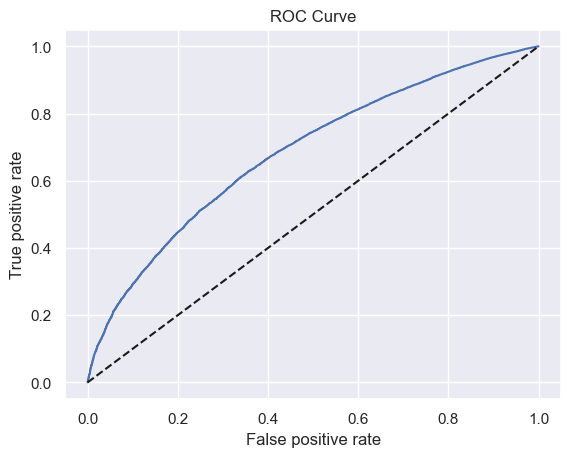

In [79]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, threshold = roc_curve(data_actual_predicted_proba['data_target_test'], data_actual_predicted_proba['y_hat_test_proba'])

sns.set()
plt.plot(fpr,tpr)
plt.plot(fpr, fpr, linestyle='--', color='k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')

In [80]:
auc_roc = roc_auc_score(data_actual_predicted_proba['data_target_test'], data_actual_predicted_proba['y_hat_test_proba'])
auc_roc

0.6836432594127335

A binary classifier is **useful only** when it achieves ROC-AUC score **greater than 0.5 and as near to 1 as possible**. If a classifier yields a score **less than 0.5**, it simply means that the **model is performing worse** than a random classifier, and hence, is of no use.

## Gini

In [81]:
data_actual_predicted_proba.sample(10)

,data_target_test,y_hat_test_proba,y_hat_test
321063,1,0.915453,1
411716,1,0.866030,1
124955,1,0.944673,1
73404,0,0.750743,0
206580,1,0.957841,1
151341,1,0.877494,1
253673,1,0.856299,1
65717,1,0.929911,1
86255,1,0.882784,1
266252,1,0.947662,1


In [82]:
#In order plotting the Gini plot, we need to order the dataframe that contains the target and the probabilities
#estimated in ascending order.

data_actual_predicted_proba = data_actual_predicted_proba.sort_values('y_hat_test_proba').reset_index()

In [83]:
# What we need?
# 1. the cummulative % of total population
# 2. the cummulative % of good borrowers
# 3. the cummulative % of bad borrowers

data_actual_predicted_proba['Cummulative N Population'] = data_actual_predicted_proba.index+1
data_actual_predicted_proba['Cummulative N Good'] = data_actual_predicted_proba['data_target_test'].cumsum()
data_actual_predicted_proba['Cummulative N Bad'] = data_actual_predicted_proba['Cummulative N Population'] - data_actual_predicted_proba['data_target_test'].cumsum()

In [84]:
data_actual_predicted_proba['Cummulative % Population'] = data_actual_predicted_proba['Cummulative N Population'] / (data_actual_predicted_proba.shape[0])
data_actual_predicted_proba['Cummulative % Good'] = data_actual_predicted_proba['Cummulative N Good'] / data_actual_predicted_proba['data_target_test'].sum()
data_actual_predicted_proba['Cummulative % Bad'] = data_actual_predicted_proba['Cummulative N Bad'] / (data_actual_predicted_proba.shape[0] - data_actual_predicted_proba['data_target_test'].sum())

In [85]:
data_actual_predicted_proba.sample(10)

,index,data_target_test,y_hat_test_proba,y_hat_test,Cummulative N Population,Cummulative N Good,Cummulative N Bad,Cummulative % Population,Cummulative % Good,Cummulative % Bad
53288,393660,1,0.924396,1,53289,46117,7172,0.571421,0.547513,0.794505
51259,44880,1,0.921567,1,51260,44228,7032,0.549664,0.525086,0.778996
86654,256075,1,0.970740,1,86655,77752,8903,0.929206,0.923092,0.986263
53509,148183,1,0.924751,1,53510,46315,7195,0.573791,0.549863,0.797053
27597,30133,1,0.882147,1,27598,22871,4727,0.295935,0.271530,0.523651
64475,120433,0,0.939629,1,64476,56544,7932,0.691380,0.671305,0.878697
73908,136935,1,0.952312,1,73909,65451,8458,0.792530,0.777051,0.936967
86471,353997,1,0.970469,1,86472,77572,8900,0.927244,0.920955,0.985931
41410,427356,1,0.907148,1,41411,35227,6184,0.444052,0.418224,0.685056
13222,198466,1,0.840098,1,13223,10563,2660,0.141791,0.125407,0.294672


Text(0.5, 1.0, 'Gini')

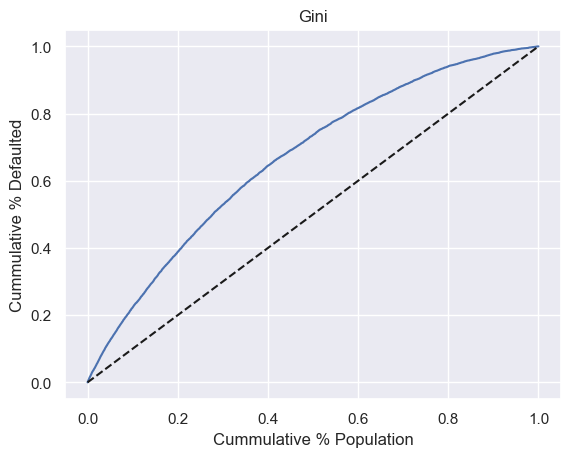

In [86]:
plt.plot(data_actual_predicted_proba['Cummulative % Population'], data_actual_predicted_proba['Cummulative % Bad'])
plt.plot(data_actual_predicted_proba['Cummulative % Population'], data_actual_predicted_proba['Cummulative % Population'], linestyle='--', color='k')
plt.xlabel('Cummulative % Population')
plt.ylabel('Cummulative % Defaulted')
plt.title('Gini')

In [87]:
gini = auc_roc*2-1
gini

0.36728651882546703

# Creating Scorecard

In [90]:
scorecard = summary_table
scorecard['Original Feature Name'] = scorecard['Feature Name'].str.split(':').str[0]

scorecard

,Feature Name,Coefficients,Original Feature Name
0,Intercept,0.40386,Intercept
1,grade:A,0.60254,grade
2,grade:B,0.35116,grade
3,grade:C,0.20646,grade
4,grade:D,0.11595,grade
5,grade:E,-0.09691,grade
6,grade:F,-0.33011,grade
7,grade:G,-0.45003,grade
8,home_ownership:RENT_OTHER_NONE_ANY,0.04268,home_ownership
9,home_ownership:MORTGAGE,0.16989,home_ownership


In [91]:
#Create a scorecard
min_score=300
max_score=850

#The minimum credit assessment is reached when a borrower falls into the 'worst' categories for all variables
#The maximum credit assessment is reached when a borrower falls into the 'best' categories for all variables
min_sum_coef = scorecard.groupby('Original Feature Name')['Coefficients'].min().sum()
max_sum_coef = scorecard.groupby('Original Feature Name')['Coefficients'].max().sum()

print(min_sum_coef)
print(max_sum_coef)

-0.4394916937257388
5.087250319781829


In [92]:
#var_score = var_coef*( (max_score - min_score) / (max_sum_coef - min_sum_coef) )

scorecard['Score'] = scorecard['Coefficients']*(max_score-min_score)/(max_sum_coef-min_sum_coef)
scorecard['Score'][0] = ((scorecard['Coefficients'][0]-min_sum_coef)/(max_sum_coef-min_sum_coef))*(max_score - min_score) + min_score

In [93]:
scorecard['Score Preliminary'] = scorecard['Score'].round()
scorecard

,Feature Name,Coefficients,Original Feature Name,Score,Score Preliminary
0,Intercept,0.40386,Intercept,383.92666,384.00000
1,grade:A,0.60254,grade,59.96197,60.00000
2,grade:B,0.35116,grade,34.94597,35.00000
3,grade:C,0.20646,grade,20.54572,21.00000
4,grade:D,0.11595,grade,11.53850,12.00000
5,grade:E,-0.09691,grade,-9.64443,-10.00000
6,grade:F,-0.33011,grade,-32.85115,-33.00000
7,grade:G,-0.45003,grade,-44.78528,-45.00000
8,home_ownership:RENT_OTHER_NONE_ANY,0.04268,home_ownership,4.24780,4.00000
9,home_ownership:MORTGAGE,0.16989,home_ownership,16.90727,17.00000


In [94]:
min_sum_score_prelim = scorecard.groupby('Original Feature Name')['Score Preliminary'].min().sum()
max_sum_score_prelim = scorecard.groupby('Original Feature Name')['Score Preliminary'].max().sum()

print(min_sum_score_prelim)
print(max_sum_score_prelim)

301.0
850.0


In [95]:
#if max score is 1 point above the desired max score, it is due to the rounding of the score
#to fix this, we can just substract the max_score with 1. It is the best practice to substract from the positive variable that was rounded the most

scorecard['Difference'] = scorecard['Score Preliminary'] - scorecard['Score']
scorecard.sort_values('Difference', ascending=False)

,Feature Name,Coefficients,Original Feature Name,Score,Score Preliminary,Difference
36,term_int:60,0.16588,term_int,16.50758,17.00000,0.49242
22,adrr_state:KY_VA,-0.08523,adrr_state,-8.48186,-8.00000,0.48186
4,grade:D,0.11595,grade,11.53850,12.00000,0.46150
3,grade:C,0.20646,grade,20.54572,21.00000,0.45428
13,ver_status:Verified,0.04576,ver_status,4.55416,5.00000,0.44584
10,home_ownership:OWN,0.18646,home_ownership,18.55623,19.00000,0.44377
52,annual_inc:30k-40k,-0.24562,annual_inc,-24.44275,-24.00000,0.44275
30,adrr_state:KS_IL_MT,0.14646,adrr_state,14.57527,15.00000,0.42473
62,mths_since_last_delinq:<=4,0.04617,mths_since_last_delinq,4.59431,5.00000,0.40569
58,annual_inc:90k-100k,0.19699,annual_inc,19.60392,20.00000,0.39608


In [96]:
#Begin the substraction process
scorecard['Score Final'] = scorecard['Score Preliminary']
scorecard['Score Final'][24] = 49

min_sum_score_final = scorecard.groupby('Original Feature Name')['Score Final'].min().sum()
max_sum_score_final = scorecard.groupby('Original Feature Name')['Score Final'].max().sum()

print(min_sum_score_final)
print(max_sum_score_final)

301.0
865.0


# Calculating Credit Score

In [97]:
selected_dummy_test_intercept = selected_dummy_test
selected_dummy_test_intercept.insert(0, 'Intercept', 1)

#make sure to set the order of the X_test as the same as the Feature Name in our scorecard
selected_dummy_test_intercept = selected_dummy_test_intercept[scorecard['Feature Name'].values]
selected_dummy_test_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:MORTGAGE,home_ownership:OWN,ver_status:Not Verified,ver_status:Source Verified,ver_status:Verified,purpose:small_business_educational_moving,purpose:renewable_energy_other_house,purpose:medical_wedding_vacation,purpose:debt_consolidation,purpose:home_improvement_major_purchase_car,purpose:credit_card,adrr_state:NE_IA_NV_FL_AL_NM_HI_MO,adrr_state:CA,adrr_state:KY_VA,adrr_state:NY,adrr_state:NC_UT,adrr_state:MD_NJ_LA_OK_MI_TN,adrr_state:MN_AZ_DE_PA_AR_OH,adrr_state:WA_MA_IN_GA_RI_OR,adrr_state:WI_SD_CT,adrr_state:TX,adrr_state:KS_IL_MT,adrr_state:CO_SC_VT_AK,adrr_state:MS_NH_WY_WV_DC_ME_ID,list_status:f,list_status:w,term_int:36,term_int:60,int_rate:<=10,int_rate:10-15,int_rate:15-20,int_rate:>=20,delinq_2yrs:<=1,delinq_2yrs:>1,inq_last_6mths:<=1,inq_last_6mths:>1,open_acc:<=8,open_acc:8-14,open_acc:>14,pub_rec:<=1,pub_rec:>1,annual_inc:<20k,annual_inc:20k-30k,annual_inc:30k-40k,annual_inc:40k-50k,annual_inc:50k-60k,annual_inc:60k-70k,annual_inc:70k-80k,annual_inc:80k-90k,annual_inc:90k-100k,annual_inc:100k-120k,annual_inc:120k-140k,annual_inc:>140k,mths_since_last_delinq:<=4,mths_since_last_delinq:4-30,mths_since_last_delinq:>30,dti:<=10,dti:10-15,dti:15-20,dti:20-25,dti:>25
362514,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
288564,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
213591,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
263083,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
165001,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0


In [98]:
scorecard_score = scorecard['Score Final']

In [99]:
selected_dummy_test_intercept.shape

(93257, 70)

In [100]:
scorecard_score.shape

(70,)

In [101]:
#the dimenssion between X_test_with_ref_and_intercept and scorecard_scores need to be the same (The X_Test dimenssion is 2, so we need to reshape the dimenssion of the scorecard_scores to be the same)
scorecard_score = scorecard_score.values.reshape(70,1)

In [102]:
y_scores = selected_dummy_test_intercept.dot(scorecard_score)
y_scores.head()

,0
362514,562.00000
288564,530.00000
213591,619.00000
263083,601.00000
165001,695.00000


## Convert Scorecard into PD

In [103]:
# Convert Credit Score to PD (Probability of Default)
sum_of_coef_from_score = ((y_scores-min_score)/(max_score - min_score))*(max_sum_coef - min_sum_coef) + min_sum_coef

y_hat_proba_from_score = np.exp(sum_of_coef_from_score) / (np.exp(sum_of_coef_from_score) + 1)
y_hat_proba_from_score.head()

,0
362514,0.89964
288564,0.86665
213591,0.94081
263083,0.92990
165001,0.97152


In [104]:
cutoffs = pd.concat([pd.DataFrame(threshold), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis=1)
cutoffs.columns = ['threshold','fpr','tpr']
cutoffs.head()

,threshold,fpr,tpr
0,1.99068,0.00000,0.00000
1,0.99068,0.00000,0.00001
2,0.98764,0.00000,0.00043
3,0.98763,0.00000,0.00045
4,0.98755,0.00000,0.00046


In [105]:
# Adjusting the first row of the cutoffs
cutoffs['threshold'][0] = 1-1/np.power(10,6)

cutoffs['Score'] = ((np.log(cutoffs['threshold']/(1-cutoffs['threshold']))- min_sum_coef) * ((max_score - min_score)/ (max_sum_coef - min_sum_coef)) + min_score).round()
cutoffs['Score'][0] = max_score
cutoffs.head()

,threshold,fpr,tpr,Score
0,1.00000,0.00000,0.00000,850.00000
1,0.99068,0.00000,0.00001,808.00000
2,0.98764,0.00000,0.00043,780.00000
3,0.98763,0.00000,0.00045,780.00000
4,0.98755,0.00000,0.00046,779.00000


Total = Number of Approved + Number of Rejected<br>
Approval Rate = Number of Approved / Total<br>
Rejected Rate = Number of Rejected / Total or 1 - Approval Rate

In [106]:
def n_approved(n):
    return np.where(data_actual_predicted_proba['y_hat_test_proba'] >= n, 1, 0).sum()

In [107]:
cutoffs['N Approved'] = cutoffs['threshold'].apply(n_approved)
cutoffs['N Rejected'] = data_actual_predicted_proba['y_hat_test_proba'].shape[0] - cutoffs['N Approved']

cutoffs['Approval Rate'] = cutoffs['N Approved'] / data_actual_predicted_proba['y_hat_test_proba'].shape[0]
cutoffs['Rejected Rate'] = 1 - cutoffs['Approval Rate']

In [112]:
cutoffs.tail()

,threshold,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejected Rate
21933,0.57227,0.99945,0.99989,373.00000,93243,14,0.99985,0.00015
21934,0.56711,0.99978,0.99989,371.00000,93246,11,0.99988,0.00012
21935,0.52617,0.99978,0.99998,354.00000,93253,4,0.99996,0.00004
21936,0.51664,1.00000,0.99998,350.00000,93255,2,0.99998,0.00002
21937,0.49757,1.00000,1.00000,343.00000,93257,0,1.00000,0.00000
